In [ ]:
# Detect environment
#if 'google.colab' in sys.modules:
    #colab_env = True
    #print('Colab is detected\nMounting Google Drive for source files')
    # Mount the drive folder that contains tests and all datasets
    #from google.colab import drive
    # put the project folder to the root of google drive if running in colab
    #drive.mount('/content/drive', force_remount=True)
    #os.chdir('/content/drive/MyDrive/Data_C200_Final_Project_Part_2')
    # Initialize Otter
else:
    #colab_env = False
    # Initialize Otter
    #grader = otter.Notebook('AQI.ipynb')
    # Change the os directory to project root that contains 'data/' if needed
    # os.chdir('path/to/project/root')
    


In [5]:
import sys, os
colab_env = False
# Detect environment
if 'google.colab' in sys.modules:
    print('Colab is detected')
    project_path = '/content/Data_C200_Final_Project_Part_2'
    if not os.path.exists(project_path):
        os.mkdir(project_path)
    os.chdir(project_path)
    !pip install gdown --quiet
    import gdown, zipfile
    # Download datasets used by this project
    if not os.path.exists('data'):
        print('\'data/\' does not exist')
        data_url = 'https://drive.google.com/u/1/uc?id=1QhryFoiUduLL0iuwdIJMyKrbb2RaX9L_'
        gdown.download(data_url, 'data.zip', False)
        with zipfile.ZipFile('data.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall()
        if not os.path.exists('data'): sys.exit('Cannot download source files')
    if not os.path.exists('images'):
        print('\'images/\' does not exist')
        images_url = 'https://drive.google.com/u/1/uc?id=1aHJ1hAx0-QiAOLLFQo2oUve2dRowfjL6'
        gdown.download(images_url, 'images.zip', False)
        with zipfile.ZipFile('images.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall()
        if not os.path.exists('images'): sys.exit('Cannot download source files')
    if not os.path.exists('tests'):
        print('\'tests/\' does not exist')
        tests_url = 'https://drive.google.com/u/1/uc?id=1sXm8m9q9pEG_6IMWSRjdOzcF9OrW3l9T'
        gdown.download(tests_url, 'tests.zip', False)
        with zipfile.ZipFile('tests.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall()
        if not os.path.exists('tests'): sys.exit('Cannot download source files')

    colab_env = True

if not colab_env:
    print('Running locally')
    # Initialize Otter
    # Change the os directory to project root that contains 'test/' and 'data/' if needed
    # os.chdir('path/to/project/root')

Running locally


# Air Quality Forecasting Neural Network 

We will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. 

Through this final project, we will do the following:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

To skip to the code and analysis of the AQI Forecasting Temporal Fusion Transformer Neural Network, click [here](#AQI_Neural_Network_Model)


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

!pip install geopandas --user --quiet
!pip install pygeos --user --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.axes._axes import _log as axes_logger
axes_logger.setLevel('ERROR')

import re, gc, os, warnings
import requests, zipfile, io
import geopandas as gpd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    KFold
)
from sklearn.metrics import log_loss



You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = "https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames

name               epa_filename
0  annual_county_aqi  annual_aqi_by_county_2020
1   daily_county_aqi   daily_aqi_by_county_2020
2        daily_ozone           daily_44201_2020
3          daily_so2           daily_42401_2020
4           daily_co           daily_42101_2020
5          daily_no2           daily_42602_2020
6         daily_temp            daily_WIND_2020
7         daily_wind            daily_TEMP_2020
8          aqs_sites                  aqs_sites

In [4]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    print(name, filename)
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        print(path_name+' does not exist')
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

annual_county_aqi annual_aqi_by_county_2020
daily_county_aqi daily_aqi_by_county_2020
daily_ozone daily_44201_2020
daily_so2 daily_42401_2020
daily_co daily_42101_2020
daily_no2 daily_42602_2020
daily_temp daily_WIND_2020
daily_wind daily_TEMP_2020
aqs_sites aqs_sites


In [5]:
epa_data.get('annual_county_aqi').head()

State   County  Year  Days with AQI  Good Days  Moderate Days  \
0  Alabama  Baldwin  2020            269        250             19   
1  Alabama     Clay  2020            108         99              9   
2  Alabama   DeKalb  2020            364        350             14   
3  Alabama   Elmore  2020            197        197              0   
4  Alabama   Etowah  2020            278        260             18   

   Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days  \
0                                    0               0                    0   
1                                    0               0                    0   
2                                    0               0                    0   
3                                    0               0                    0   
4                                    0               0                    0   

   Hazardous Days  Max AQI  90th Percentile AQI  Median AQI  Days CO  \
0               0       74                   49          36        0   
1               0       86                   49          26        0   
2               0       90                   45          36        0   
3               0       47                   41          31        0   
4               0       92                   46          34        0   

   Days NO2  Days Ozone  Days SO2  Days PM2.5  Days PM10  
0         0         198         0          71          0  
1         0           0         0         108          0  
2         0         331         0          33          0  
3         0         197         0           0          0  
4         0         204         0          74          0

### Creating Month and Day Columns

In [6]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.DatetimeIndex(daily_county['Date']).month
daily_county['Day'] = pd.DatetimeIndex(daily_county['Date']).day

daily_county.head()

State Name county Name  State Code  County Code        Date  AQI Category  \
0    Alabama     Baldwin           1            3  2020-01-01   48     Good   
1    Alabama     Baldwin           1            3  2020-01-04   13     Good   
2    Alabama     Baldwin           1            3  2020-01-07   14     Good   
3    Alabama     Baldwin           1            3  2020-01-10   39     Good   
4    Alabama     Baldwin           1            3  2020-01-13   29     Good   

  Defining Parameter Defining Site  Number of Sites Reporting  Month  Day  
0              PM2.5   01-003-0010                          1      1    1  
1              PM2.5   01-003-0010                          1      1    4  
2              PM2.5   01-003-0010                          1      1    7  
3              PM2.5   01-003-0010                          1      1   10  
4              PM2.5   01-003-0010                          1      1   13

In [8]:
epa_data_CA = {}

for filename, df in epa_data.items():
    if "daily" not in filename: continue  # only extract daily data
    epa_data_CA[filename] = df[df["State Name"] == "California"]
    
epa_data_CA.get('daily_county_aqi').head()

State Name county Name  State Code  County Code        Date  AQI  \
14003  California     Alameda           6            1  2020-01-01   53   
14004  California     Alameda           6            1  2020-01-02   43   
14005  California     Alameda           6            1  2020-01-03   74   
14006  California     Alameda           6            1  2020-01-04   45   
14007  California     Alameda           6            1  2020-01-05   33   

       Category Defining Parameter Defining Site  Number of Sites Reporting  \
14003  Moderate              PM2.5   06-001-0009                          7   
14004      Good              PM2.5   06-001-0013                          7   
14005  Moderate              PM2.5   06-001-0013                          7   
14006      Good              PM2.5   06-001-0007                          7   
14007      Good              PM2.5   06-001-0007                          7   

       Month  Day  
14003      1    1  
14004      1    2  
14005      1    3  
14006      1    4  
14007      1    5

### Merging Site Information

In [10]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']

lambda_defining_site = lambda x: f"{x['State Code']}-{int(x['County Code']):03d}-{int(x['Site Number']):04d}"

lambda_defining_site_ca = lambda x: f"6_{int(x['County Code']):03d}"

def intro_location(df, level=''):
    if level == '':
        site_locations = epa_data.get('aqs_sites')[['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude']]
        site_locations['Defining Site'] = site_locations.apply(lambda_defining_site, axis=1)
        return df.merge(how="left", right = site_locations, on = ["Defining Site"])[cols]
    elif level == 'ca':
        # merge on county level for CA, used for modeling
        site_locations = epa_data.get('aqs_sites')[['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude', 'Elevation']]
        site_locations = site_locations[site_locations['State Code'] == '06']
        site_locations['state_county'] = site_locations.apply(lambda_defining_site_ca, axis=1)
        site_locations = site_locations.groupby('state_county')[['Latitude', 'Longitude', 'Elevation']].mean().reset_index()
        return df.merge(how="left", right = site_locations, on = ["state_county"])

epa_data_CA_merged = intro_location(epa_data_CA.get('daily_county_aqi'))
epa_data_CA_merged.head()

State Name county Name  Month  Day  AQI  Category Defining Site   Latitude  \
0  California     Alameda      1    1   53  Moderate   06-001-0009  37.743065   
1  California     Alameda      1    2   43      Good   06-001-0013  37.864767   
2  California     Alameda      1    3   74  Moderate   06-001-0013  37.864767   
3  California     Alameda      1    4   45      Good   06-001-0007  37.687526   
4  California     Alameda      1    5   33      Good   06-001-0007  37.687526   

    Longitude  
0 -122.169935  
1 -122.302741  
2 -122.302741  
3 -121.784217  
4 -121.784217

### Cleaning Traffic Data 

In [12]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")

# clean AADT invalid data
traffic_data["Back_AADT"] = traffic_data["Back_AADT"].str.replace(" ", "0")
traffic_data["Ahead_AADT"] = traffic_data["Ahead_AADT"].str.replace(" ", "0")
traffic_data["AADT"] = traffic_data["Back_AADT"].astype(int) + traffic_data["Ahead_AADT"].astype(int)

# clean long / lat invalid data
# latitude and longitude should be in the form of (int).(int) or -(int).(int)
traffic_data = traffic_data[traffic_data["Lon_S_or_W"].str.match(r"\d*\.\d*|-\d*\.\d*") & traffic_data["Lat_S_or_W"].str.match(r"\d*\.\d*|-\d*\.\d*")]
traffic_data["Longitude"] = traffic_data["Lon_S_or_W"].astype("float64")
traffic_data["Latitude"] = traffic_data["Lat_S_or_W"].astype("float64")

cols = ["District", "Route", "County", "Descriptn", "AADT", "Latitude", "Longitude"]
traffic_data_cleaned = traffic_data[cols]

traffic_data_cleaned.head()

District  Route County                       Descriptn  AADT   Latitude  \
0         1      1    MEN    SONOMA/MENDOCINO COUNTY LINE  4000  38.759843   
1         1      1    MEN            NORTH LIMITS GUALALA  7100  38.770046   
2         1      1    MEN                  FISH ROCK ROAD  6200  38.803549   
3         1      1    MEN  POINT ARENA, SOUTH CITY LIMITS  4600  38.903973   
4         1      1    MEN    POINT ARENA, RIVERSIDE DRIVE  5000  38.910913   

    Longitude  
0 -123.518503  
1 -123.531890  
2 -123.585411  
3 -123.691513  
4 -123.692410

### Merging on Traffic Data 

In [14]:
gpd_epa = gpd.GeoDataFrame(epa_data_CA_merged.copy(), geometry=gpd.points_from_xy(epa_data_CA_merged.Longitude, epa_data_CA_merged.Latitude))
gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned.copy(), geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude))

cols = ["State Name", "county Name", "Month", "Day", "AQI", "Category", "Defining Site", "Site Lat", "Site Long", "Traffic Lat", "Traffic Long", "Descriptn", "AADT"]
gpd_epa_traffic = gpd.sjoin_nearest(gpd_epa, gpd_traffic)
gpd_epa_traffic = gpd_epa_traffic.rename(columns={"Latitude_left": "Site Lat", "Longitude_left": "Site Long", "Latitude_right": "Traffic Lat", "Longitude_right": "Traffic Long"})
gpd_epa_traffic = gpd_epa_traffic[cols]

#not sure if we need the last line or not
gpd_epa_traffic.head()

State Name county Name  Month  Day  AQI                        Category  \
0    California     Alameda      1    1   53                        Moderate   
24   California     Alameda      1   25   40                            Good   
184  California     Alameda      7    3   48                            Good   
185  California     Alameda      7    4  115  Unhealthy for Sensitive Groups   
186  California     Alameda      7    5   78                        Moderate   

    Defining Site   Site Lat   Site Long  Traffic Lat  Traffic Long  \
0     06-001-0009  37.743065 -122.169935    37.744352   -122.170586   
24    06-001-0009  37.743065 -122.169935    37.744352   -122.170586   
184   06-001-0009  37.743065 -122.169935    37.744352   -122.170586   
185   06-001-0009  37.743065 -122.169935    37.744352   -122.170586   
186   06-001-0009  37.743065 -122.169935    37.744352   -122.170586   

                Descriptn   AADT  
0    OAKLAND, 98TH AVENUE  48300  
24   OAKLAND, 98TH AVENUE  48300  
184  OAKLAND, 98TH AVENUE  48300  
185  OAKLAND, 98TH AVENUE  48300  
186  OAKLAND, 98TH AVENUE  48300

<br/><br/>

---
## EDA Continued


In [16]:
gb = epa_data["annual_county_aqi"][["State", "Max AQI", "Median AQI"]].groupby("State").mean().rename(columns={"Median AQI": "Average Median AQI", "Max AQI": "Average Max AQI"})

gb = gb[~gb.index.isin(["Country Of Mexico", "District Of Columbia", "Puerto Rico", "Virgin Islands"])]

worst_median_aqis = gb.sort_values("Average Median AQI", ascending = False)["Average Median AQI"][:10]
worst_max_aqis = gb.sort_values("Average Max AQI", ascending = False)["Average Max AQI"][:10]

print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

print(worst_median_aqis.index & worst_max_aqis.index)
np.round(list(worst_max_aqis), 2)

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Average Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Average Max AQI, dtype: float64
Index(['California', 'Arizona', 'Connecticut', 'Nevada'], dtype='object', name='State')


array([430.35, 334.42, 286.98, 238.23, 197.86, 196.67, 196.67, 137.42,
       133.  , 124.75])

In [18]:
us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

gb = epa_data["annual_county_aqi"][["State", "Days with AQI"]].groupby("State").mean()
gb = gb[gb.index.isin(us_states)]

days_with_AQI = gb.sort_values("Days with AQI")["Days with AQI"]

days_with_AQI.head()

State
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: Days with AQI, dtype: float64

In [23]:
epa_daily_county_aqi = epa_data.get('daily_county_aqi')
# uncomment to filter only US states
# epa_daily_county_aqi = epa_daily_county_aqi[epa_daily_county_aqi['State Name'].isin(us_states)]
aqi_per_month = epa_daily_county_aqi.groupby('Month').mean()['AQI']
aqi_per_month_CA = epa_data_CA.get('daily_county_aqi').groupby('Month').mean()['AQI']

print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [25]:
# set endpoint's False to get the correct result, set True to pass tests
def bucket_data(table, aggfunc, resolution):
    my_table = table.copy()
    long_min = my_table['Longitude'].min()
    long_max = my_table['Longitude'].max()
    long_bucket = np.linspace(long_min, long_max, resolution, endpoint=False)
    my_table['long_bucket'] = pd.cut(my_table.Longitude,
                                     np.append(long_bucket - 0.00000001, 999),
                                     labels=np.around(long_bucket, decimals=2)
                                    )
    lat_min = my_table['Latitude'].min()
    lat_max = my_table['Latitude'].max()
    lat_bucket = np.linspace(lat_min, lat_max, resolution, endpoint=False)
    my_table['lat_bucket'] = pd.cut(my_table.Latitude,
                                    np.append(lat_bucket - 0.00000001, 999),
                                    labels=np.around(lat_bucket, decimals=2)
                                   )
    pvt_table = my_table.pivot_table(index=['lat_bucket'],
                                     columns=['long_bucket'], 
                                     values=['AQI'],
                                     aggfunc=aggfunc
                                    )
    return pvt_table

bucket_data(epa_data_CA_merged, np.mean, 5)

AQI                                            
long_bucket     -124.2    -122.28    -120.36    -118.44    -116.52
lat_bucket                                                        
32.58              NaN        NaN  65.317391  87.059645  67.955508
34.41              NaN  50.221983  67.597970  74.442308  58.294118
36.25        42.792276  51.489882  81.094254  74.704918        NaN
38.08        38.934803  53.699484  48.977778        NaN        NaN
39.92        38.790792  55.207065        NaN        NaN        NaN

###  Heatmap

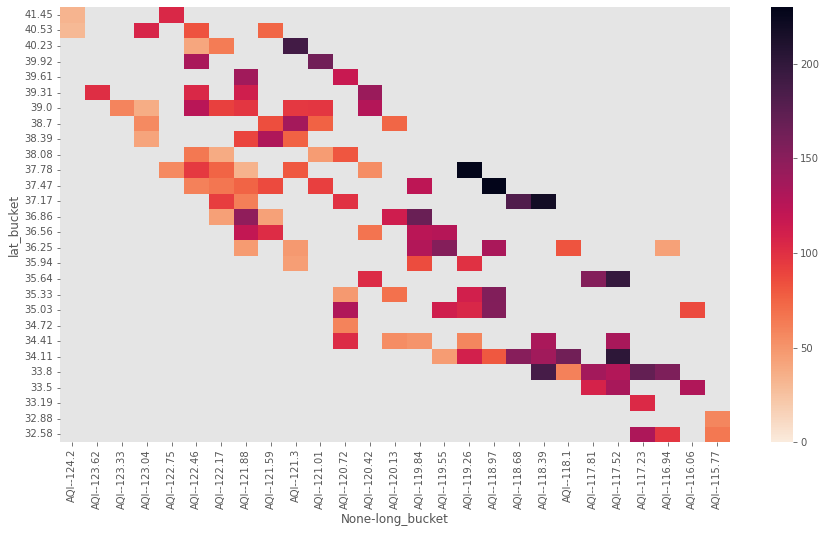

In [27]:
heatmap_data = bucket_data(epa_data_CA_merged[epa_data_CA_merged['Month'] == 9], np.median, 30)

#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

### Code and Analysis

In [29]:
# Join CA counties Daily AQI with, ozone, so2, co, no2, temp, wind
epa_data_CA_aqi = epa_data_CA.get("daily_county_aqi").copy()
epa_data_CA_aqi["Site Num"] = epa_data_CA_aqi["Defining Site"].str.split("-").str[2].astype("int32")
epa_data_CA_aqi = epa_data_CA_aqi[["State Code", "County Code", "Site Num", "Date", "AQI"]]

for feature in ["ozone", "so2", "co", "no2", "temp", "wind"]:
    epa_data_CA_feature = epa_data_CA.get(f"daily_{feature}").copy().rename(columns={"Date Local": "Date", "Arithmetic Mean": f"{feature}"})
    epa_data_CA_feature = epa_data_CA_feature[["State Code", "County Code", "Site Num", "Date", f"{feature}"]]
    epa_data_CA_feature = epa_data_CA_feature.groupby(["State Code", "County Code", "Site Num", "Date"]).mean() # because there might be multiple data in a single date
    epa_data_CA_aqi = epa_data_CA_aqi.merge(
                        right = epa_data_CA_feature,
                        on = ["State Code", "County Code", "Site Num", "Date"]
                    )
# epa_data_CA_aqi.head()

# PCA CA counties Monthly Mean AQI
CA_aqi_monthly = pd.pivot_table(epa_data_CA_merged[['county Name', 'Month', 'AQI']],
                                values='AQI',
                                index='county Name',
                                columns='Month',
                                aggfunc='mean'
                               )
CA_aqi_monthly = CA_aqi_monthly.drop(index=['Del Norte'])
CA_aqi_monthly_standardized = (CA_aqi_monthly - np.mean(CA_aqi_monthly)) / np.std(CA_aqi_monthly)

u, s, vt = np.linalg.svd(CA_aqi_monthly_standardized, full_matrices = False)
CA_aqi_first_2_pcs = pd.DataFrame(CA_aqi_monthly_standardized @ vt[0:2].T) \
                                .reset_index()[[0, 1]].rename(columns = {0:'pc1', 1:'pc2'})
variance_explained = pd.Series(s**2 / sum(s**2), index=np.arange(1, 13))

# merge CA daily AQI with wind and temp
def clean_CA_daily_wind_temp(data):
    data = data[data['State Code'] == 6][['County Code', 'Arithmetic Mean', 'Date Local']]
    data = data.groupby(['County Code', 'Date Local']).mean().reset_index()
    data['Month'] = pd.DatetimeIndex(data['Date Local']).month
    data['Day'] = pd.DatetimeIndex(data['Date Local']).day
    return data

epa_CA_daily_temp = clean_CA_daily_wind_temp(epa_data.get('daily_wind')) \
                                .rename(columns={'Arithmetic Mean':'Mean Temp Degrees Fahrenheit'})
epa_CA_daily_wind = clean_CA_daily_wind_temp(epa_data.get('daily_temp')) \
                                .rename(columns={'Arithmetic Mean':'Mean Wind Speed Knot'})

cols_CA_7a_aqi_wind_temp = ['county Name', 'County Code', 'Month', 'Day', 'AQI']
epa_data_CA_merged_temp_wind = epa_data_CA_merged.copy()
epa_data_CA_merged_temp_wind['County Code'] = epa_data_CA_merged_temp_wind['Defining Site'].str.split('-').str[1].astype('int32')
epa_data_CA_merged_temp_wind = pd.merge(epa_data_CA_merged_temp_wind,
                                        epa_CA_daily_temp,
                                        how='inner',
                                        on=['County Code', 'Month', 'Day']
                                       )[np.append(cols_CA_7a_aqi_wind_temp, 'Mean Temp Degrees Fahrenheit')]
epa_data_CA_merged_temp_wind = pd.merge(epa_data_CA_merged_temp_wind,
                                        epa_CA_daily_wind,
                                        how='inner',
                                        on=['County Code', 'Month', 'Day']
                                       )[np.append(cols_CA_7a_aqi_wind_temp, ['Mean Temp Degrees Fahrenheit', 'Mean Wind Speed Knot'])]
corr = pd.DataFrame(epa_data_CA_merged_temp_wind[['county Name', 'AQI', 'Mean Temp Degrees Fahrenheit', 'Mean Wind Speed Knot']] \
                    .groupby('county Name').mean() \
                    .rename(columns={'Mean Temp Degrees Fahrenheit':'Temperature', 'Mean Wind Speed Knot':'Wind Speed'}) \
                    .corr())

# counties with highest annual median AQI
counties_highest_annual_median_AQI = epa_data_CA_merged.groupby('county Name')[['AQI']].median().sort_values('AQI', ascending=False)
epa_data_CA_merged_highest_10 = epa_data_CA_merged[epa_data_CA_merged['county Name'] \
                                                    .isin(counties_highest_annual_median_AQI.index[0:10])]

print("CA counties monthly mean AQI variance explained by each PC: \n{}\n".format(variance_explained))
print("CA counties annual mean AQI, temperature and wind speed correlation: \n{}\n".format(corr))
print("CA counties with highest annual median AQI: \n{}\n".format(counties_highest_annual_median_AQI.head(10)))

CA counties monthly mean AQI variance explained by each PC: 
1     0.646816
2     0.195906
3     0.078057
4     0.032231
5     0.015008
6     0.009794
7     0.007548
8     0.006891
9     0.003239
10    0.002240
11    0.001617
12    0.000653
dtype: float64

CA counties annual mean AQI, temperature and wind speed correlation: 
                  AQI  Temperature  Wind Speed
AQI          1.000000     0.262156    0.157837
Temperature  0.262156     1.000000    0.458807
Wind Speed   0.157837     0.458807    1.000000

CA counties with highest annual median AQI: 
                 AQI
county Name         
San Bernardino  93.0
Riverside       87.0
Los Angeles     83.0
Kern            81.0
Tulare          77.5
Fresno          74.0
San Diego       71.0
Kings           67.0
Madera          60.5
Imperial        58.0



<Figure size 540x540 with 0 Axes>

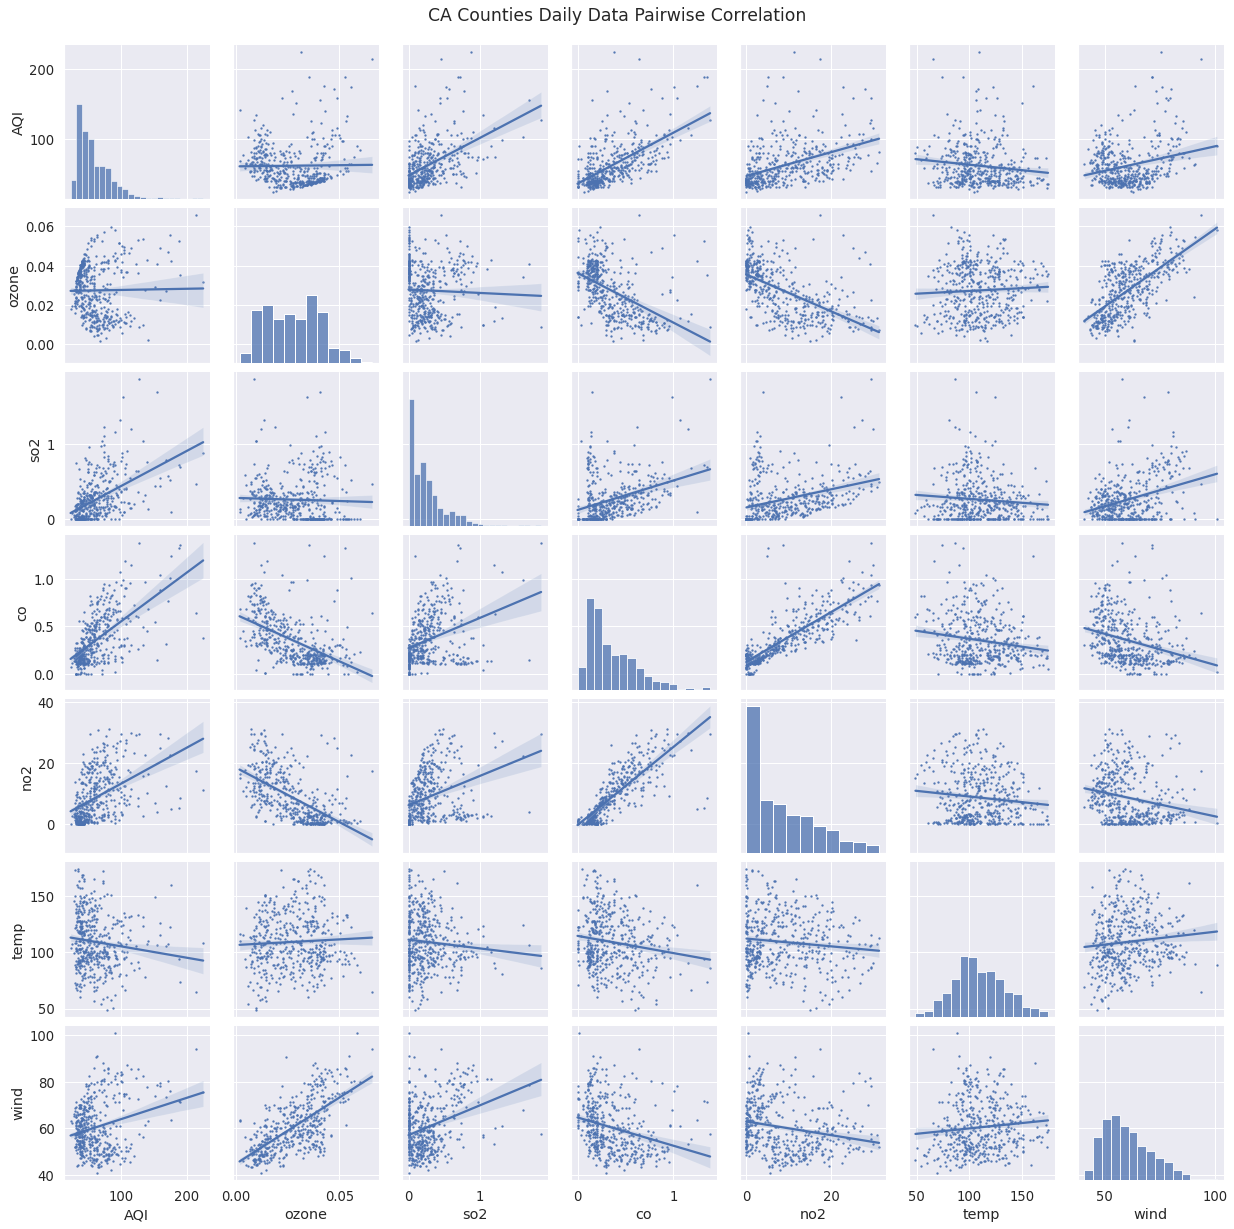

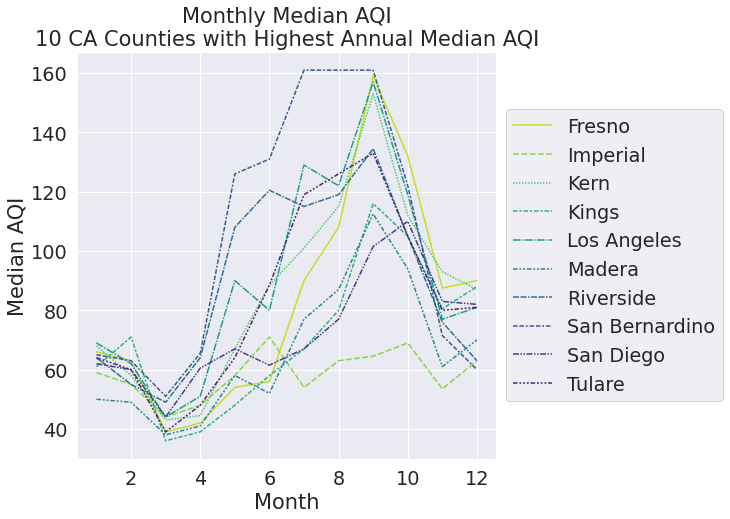

In [30]:
# Visualization 1: CA Counties Daily Data Pairwise Correlation
plt.rcParams["figure.figsize"] = (7.5,7.5);
plt.figure();
sns.set(font_scale = 1.2);
pp = sns.pairplot(epa_data_CA_aqi,
                  vars=["AQI", "ozone", "so2", "co", "no2", "temp", "wind"],
                  palette='rocket',
                  kind="reg",
                  plot_kws={'scatter_kws':{'s':2}}
                 );
pp.fig.subplots_adjust(top=0.95);
pp.fig.suptitle('CA Counties Daily Data Pairwise Correlation');

# Visualization 2: Monthly Median AQI in CA Counties with Highest Annual Median AQI
plt.figure();
sns.set(font_scale = 1.75);
lp = sns.lineplot(data=epa_data_CA_merged_highest_10.groupby(['county Name', 'Month']).median(), 
                  x='Month', y='AQI',
                  hue='county Name', style='county Name',
                  palette='viridis_r'
                 );
lp.set_ylabel("Median AQI");
lp.set_title("Monthly Median AQI\n10 CA Counties with Highest Annual Median AQI");
lp.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show();

#To view the below visualizations uncomment them
# Visualization 3: CA Counties Monthly Pct Air Pollution Days by Mean Temperature and Wind Speed
# air_pollution_days_categories = ['[0, 5%]', '(5%, 25%]', '(25%, 50%]', '(50%, 75%]', '(75%, 100%]']

# def categorize_pct_pollution_days(x):
#     if x['Pct Air Pollution Days'] <= 0.05: return air_pollution_days_categories[0]
#     if x['Pct Air Pollution Days'] <= 0.25: return air_pollution_days_categories[1]
#     if x['Pct Air Pollution Days'] <= 0.50: return air_pollution_days_categories[2]
#     if x['Pct Air Pollution Days'] <= 0.75: return air_pollution_days_categories[3]
#     return air_pollution_days_categories[4]

# def group_aqi_temp_wind_by_county(data):
#     data['Pct Air Pollution Days'] = data['AQI']
#     return data[['county Name', 'AQI', 'Pct Air Pollution Days', 'Mean Temp Degrees Fahrenheit', 'Mean Wind Speed Knot', 'Month']] \
#                 .groupby(['county Name', 'Month']) \
#                 .agg({'AQI': 'median',
#                       'Pct Air Pollution Days': lambda x: (x > 100.0).sum() / len(x),
#                       'Mean Temp Degrees Fahrenheit': 'mean',
#                       'Mean Wind Speed Knot': 'mean'
#                     }) \
#                 .reset_index()

# aqi_temp_wind_by_month_county = group_aqi_temp_wind_by_county(epa_data_CA_merged_temp_wind)
# aqi_temp_wind_by_month_county['Pct Air Pollution Days Category'] = \
#                 aqi_temp_wind_by_month_county.apply(categorize_pct_pollution_days, axis=1)
# sns.set(font_scale = 1.75);
# lp = sns.lmplot(data=aqi_temp_wind_by_month_county,
#                 x='Mean Temp Degrees Fahrenheit',
#                 y='Mean Wind Speed Knot',
#                 hue='Pct Air Pollution Days Category',
#                 hue_order=air_pollution_days_categories,
#                 palette='rocket_r',
#                 fit_reg=False,
#                 col='county Name',
#                 col_wrap=5,
#                 scatter_kws={"s": 50}
#                );
# lp.fig.subplots_adjust(top=0.95);
# lp.fig.suptitle('CA Counties Monthly Pct Air Pollution Days by Mean Temperature and Wind Speed');

# Visualization 4: CA Counties Monthly Mean AQI First Two PCs
# import plotly.express as px
# CA_aqi_first_2_pcs['county'] = list(CA_aqi_monthly_standardized.index)
# fig = px.scatter(CA_aqi_first_2_pcs,
#                  x='pc1', y='pc2',
#                  text='county',
#                  title='CA Counties Monthly Mean AQI First Two PCs',
#                  width=800, height=800
#                 );
# fig.update_traces(textposition='top center');
# fig.show();

# Further EDA with five years data
# five_year_df = pd.read_csv('data/data_extended/5_years.csv')
# aqi_ca = five_year_df[five_year_df['state_county'].str.contains(r"^6_.*")] \
#                 .reset_index().drop(['index'], axis=1)

# ca_filtered = aqi_ca[['Date', 'AQI', 'state_county']]
# ca_filtered['month'] = pd.DatetimeIndex(ca_filtered['Date']).month
# ca_filtered['year'] = pd.DatetimeIndex(ca_filtered['Date']).year
# ca_filtered['week'] = pd.DatetimeIndex(ca_filtered['Date']).weekofyear
# ca_filtered['day of year'] = pd.DatetimeIndex(ca_filtered['Date']).dayofyear

# Visualization 5: CA AQI 5 year trend
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.figure(figsize=(18, 5), dpi=100);
# sns.set_style(style='white');
# lp = sns.lineplot(x=ca_filtered['Date'], y=ca_filtered['AQI'], linewidth=0.75, color='r');
# for ind, label in enumerate(lp.get_xticklabels()):
#     if ind % 100 == 0:
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
# plt.xticks(rotation=45);
# lp.set_ylim(20, 220);
# plt.title('California Counties AQI Trend 2016 - 2020');

# Visualize 6: CA AQI vs. shelter in place
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# day_shelter_in_place = pd.Period('3-20-2020').dayofyear
# ca_filtered = ca_filtered[np.abs(ca_filtered['day of year'] - 30 - day_shelter_in_place) < 90]
# ca_filtered['shelter in place'] = ca_filtered['day of year'] >= day_shelter_in_place
# ca_19_20 = ca_filtered[ca_filtered['year'].isin([2019, 2020])]
# plt.figure(figsize=(18, 5), dpi=100)
# lp = sns.lineplot(x=ca_19_20['day of year'], y=ca_19_20['AQI'],
#                   hue=ca_19_20['year'].astype('str'),
#                   style=ca_19_20['shelter in place'],
#                   hue_order=['2020', '2019'],
#                   style_order=[True, False],
#                   linewidth=0.75
#                   );
# lp.set_ylim(20, 170);
# plt.axvline(x=80, linewidth=2, color=(0, 0, 0, 0.25));
# plt.title('California Counties Average AQI wrt. the Shelter in Place Order (day {})'.format(day_shelter_in_place));

# Visualization 7: Los Angeles AQI vs. shelter in place
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# sf_19_20 = ca_19_20[ca_19_20['state_county'] == '6_019']
# plt.figure(figsize=(18, 5), dpi=100)
# lp = sns.lineplot(x=sf_19_20['day of year'], y=sf_19_20['AQI'],
#                   hue=sf_19_20['year'].astype('str'),
#                   style=sf_19_20['shelter in place'],
#                   hue_order=['2020', '2019'],
#                   style_order=[True, False],
#                   linewidth=0.75
#                   );
# lp.set_ylim(20, 170);
# plt.axvline(x=80, linewidth=2, color=(0, 0, 0, 0.25));
# plt.title('Los Angeles AQI wrt. the Shelter in Place Order (day {})'.format(day_shelter_in_place));

# Visualization 8: CA 2020 Weekly Median AQI by Climate
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.style.use('ggplot')
# plt.figure(figsize=(7, 5))
# ca_filtered = aqi_ca[['Date', 'AQI', 'state_county', 'climate']]
# ca_filtered['year'] = pd.DatetimeIndex(ca_filtered['Date']).year
# ca_filtered['week'] = pd.DatetimeIndex(ca_filtered['Date']).weekofyear
# ca_filtered = ca_filtered[ca_filtered['year'] == 2020]
# plt.figure(figsize=(10, 5))
# ca_filtered_week_median = ca_filtered.groupby(['week', 'state_county'], sort=False).median().reset_index()
# ca_filtered_week_median['climate'] = ca_filtered.groupby(['week', 'state_county'], sort=False).first().reset_index()['climate']
# sns.lineplot(x=ca_filtered['week'], y=ca_filtered['AQI'], hue=ca_filtered['climate'], style=ca_filtered['climate'])
# plt.title('California Weekly Median AQI by Climate 2020')

# Visualization 9: Counties with different climate type 2020 Each Month AQI
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# county_names = ['Alameda', 'Fresno', 'Imperial', 'Siskiyou']
# i = 0
# for cilmate in ['6_001', '6_019', '6_025', '6_093']:
#     plt.style.use('ggplot')
#     plt.figure(figsize=(8, 5))
#     ca_filtered = aqi_ca[['Date', 'AQI', 'state_county']].copy()
#     ca_filtered['year'] = pd.DatetimeIndex(ca_filtered['Date']).year
#     ca_filtered['month'] = pd.DatetimeIndex(ca_filtered['Date']).month
#     ca_filtered = ca_filtered[ca_filtered['year'] == 2020]
#     ca_filtered = ca_filtered[ca_filtered['state_county'] == cilmate]
#     ca_filtered.head()
#     sns.boxplot(x=ca_filtered['month'], y=ca_filtered['AQI'])
#     plt.title('{} Monthly AQI 2020'.format(county_names[i]))
#     i += 1

Summary of Findigs

We first decided to analyze the concentrations of certain chemical compounds in the atmosphere to determine if a correlation can be seen between the concentration of these compounds and the AQI. We decided to do this by pair plotting the concentration values of each compound against the AQI values, as can be seen in the first visualization. We also added regresson lines in every plot to take a closer look at the correlation. We can see in the plots that there seems to be relatively high correlation coefficients, hinting that there seems to be a relatively strong association between the concentration of certain compounds in the atmosphere and the AQI levels in the atmosphere. This can help us identify chemcial compounds that we can use as features to best improve the accuracy of our model. The pair plots also revealed that our model should not neccessarily be using every chemical compound as a feature. CO and NO2 have an extremely high correlation coefficient for example. This could indicate that our model should be using one of these two compounds as a feature since having them both could cause our model to have redundant features. Getting rid of redundant features can help us optimize our model. We also wanted to analyze the differences and similarities in climate patterns across different counties and figure out if a trend can be determined. We made a line plot where we plotted the Median AQI values over the span of 12 months. The different colored lines represent the Median AQI values of different counties. In this line plot, we see that the increases and decreases of Median AQI values across different counties follow a very similar pattern. More specifically speaking, the Median AQI values seem to drastically increase from March to Septemeber for all counties. The highest AQI value for ever county seems to happen around September. The Median AQI values then tend to drastically decrease after September. This hints that time is very correlated to AQI and that the months could be a very beneficial feature to have in a model. The line plot also indicates that there are some counties that have very similar Median AQI trends, such as Fresno, Imperial, and Kern. This possiby shows that using data from all of these counties to train our model can be redundant and cause our model to not be as efficient and optimized as it can be. The line plot also hints that there could potentially be clusters of counties with similar AQI values and patterns. We also performed principal component analysis (shown in the comment titled "Visualization 4" in 7b) on each CA county's monthly mean AQI. The first two principal components in PCA explaines 84% of the variance, indicating we can project the data into a two dimension space to identify the similarity of AQI changing patterns in CA counties. After the projection (plot not displayed), we can identify a cluster of counties sharing similar AQI changig pattern, includes Mendocino, Colusa, Solano, Yolo, Sonoma, Marin, San Mateo, San Francisco, Napa, Santa, San Luis Obispo, etc. We can also identify counties with very different AQI changing patterns such as Mono and San Bernardino. This suggests that building different models for different group of counties in CA could be beneficial.


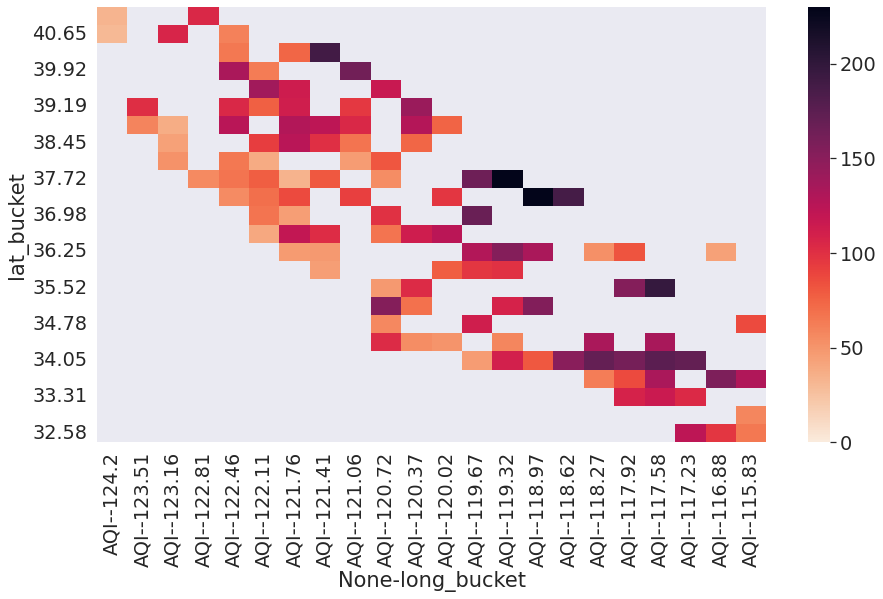

In [31]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [32]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):
    lat, lon = lat_bucket, lon_bucket
    n_rows = pivot_table.shape[0]
    n_cols = pivot_table.shape[1]
    val = pivot_table.iat[lat, lon]
    closest_cells = []
    if ~np.isnan(val):
        return val
    for a in range(lat-1, -1, -1):
        A_val = pivot_table.iat[a, lon]
        if ~np.isnan(A_val):
            closest_cells.append(A_val)
            break
    for b in range(lat+1, n_rows):
        B_val = pivot_table.iat[b, lon]
        if ~np.isnan(B_val):
            closest_cells.append(B_val)
            break
    for l in range(lon-1, -1, -1):
        L_val = pivot_table.iat[lat, l]
        if ~np.isnan(L_val):
            closest_cells.append(L_val)
            break
    for r in range(lon+1, n_cols):
        R_val = pivot_table.iat[lat, r]
        if ~np.isnan(R_val):
            closest_cells.append(R_val)
            break
    if np.size(closest_cells) >= 3:
        return np.mean(closest_cells)
    return val

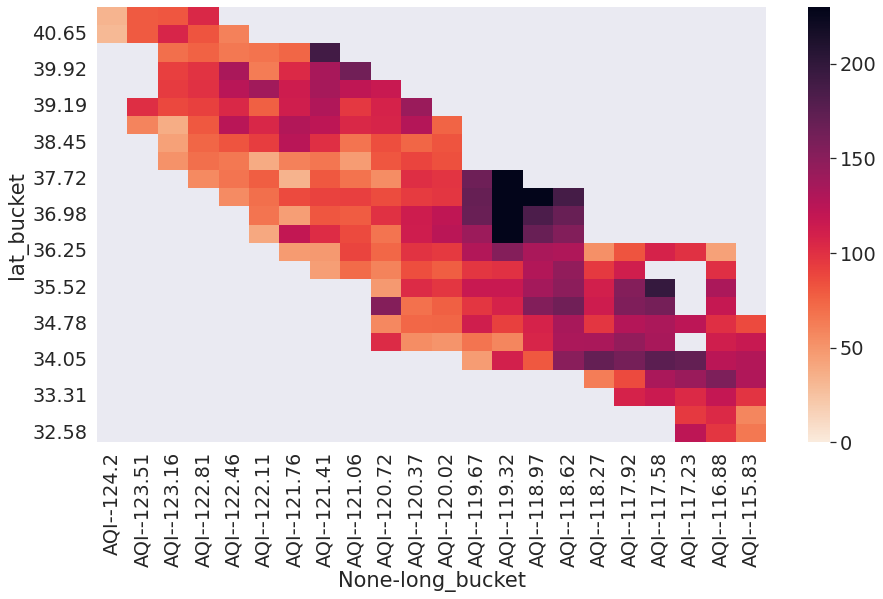

In [34]:
def fill_all(pivot_table):
    filled = pivot_table.copy()
    n_rows = pivot_table.shape[0]
    n_cols = pivot_table.shape[1]
    for lat, lon in np.ndindex((n_rows,n_cols)):
        filled.iloc[lat, lon] = fill_bucket(pivot_table, lat, lon)
    return filled

filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

## Error Loss Function

We choose to use $\text{SMAPE}$ (symmetric mean absolute percentage) as the loss function for our model. The formula of SMAPE loss is as the follow where $A_t$ stands for the actual value and $P_t$ stands for the predicted value.

$${\text{SMAPE}}={\frac {1}{n}}\sum _{t=1}^{n}{\frac {\left|P_{t}-A_{t}\right|}{(|A_{t}|+|P_{t}|)/2}}$$

We decided to use this metric because it is a better metric for measuring the inaccuracy of our model, as well as the significance of this inaccuracy, which metrics such as mean squared error are not good at showing. For example, if the real AQI is 200 and the predicted one is 210, the mean squared error is 100. If the real AQI is 0 and the predicted one is 10, the mean squared error is also 100. However, it is apparent that in the latter one, the significance of this difference is larger.


### Choosing Features and  Baseline Model

### External dataset
- Gas consumption: From California Energy Commission, the dataset contains the gas consumption of a county from 2016~2020. We assume that gas consumption can directly impact air quality.


- Wildfire: From California Natural Resource Agency, the dataset consists of wildfire records in California. The columns useful for us are `ALARM_DATE` and `FIRE_NUM`. We aggregate the fire that occurred on the same date together, and we can get the total number of fires on a date. We suppose that the occurrence of wildfire can greatly pollute the air.


- Climate type: From climatestotravel, they categorize counties in CA into different types: mediterranean, continental, semi-arid …etc. We hypothesize that different climate types should generally have different air quality.

- Other EPA datasets (From EPA): 

  - PM2.5: tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated
  - Barometric pressure: the pressure within the atmosphere of Earth
  - Rh_and_dewpoint: related to the humidity of the air

### Feature selection

Fixing the model type (logistic regression), we observe which combination of features can achieve the best performance.

Feature table
- Particulate: ozone, so2, co, no2, pm2.5
- Weather: temp, wind, barometric_pressure, rh_and_dewpoint
- Category: Date, state_county, climate type
- Other: gas, wildfire


We enumerate some of the feature combinations and observe which could achieve the best performance. Theoretically speaking, if we choose all the features, it can achieve the best performance. However, we can only select one particle, so we need to figure out which is the “rockstar” particle.

- Combination #1:
pm2.5 + all weather + all category + other
- Combination #2:
ozone + all weather + all category + other
- Combination #3:
so2 + all weather + all category + other
- Combination #4:
no2 + all weather + all category + other
- Combination #5:
co + all weather + all category + other

| Feature        | Training score | Testing score |
|----------------|----------------|---------------|
| Combination #1 | 0.8294         | 0.8274        |
| Combination #2 | 0.7244         | 0.7216        |
| Combination #3 | 0.7069         | 0.7034        |
| Combination #4 | 0.7077         | 0.7031        |
| Combination #5 | 0.7069         | 0.7036        |

We found that pm2.5 is the most impactful feature because it achieves the highest score in both training and testing dataset. It indicates that pm2.5 could be the dominant factor in AQI prediction.


### Model selection

Fixing the features (comb #1), we observe which models can achieve the best performance.

| model                  | train_score | test_score |
|------------------------|-------------|------------|
| LogisticRegression     |      0.8508 |     0.8231 |
| MLPClassifier          |      0.9934 |      0.827 |
| RandomForestClassifier |      0.7128 |     0.6972 |
| KNeighborsClassifier   |      0.9913 |     0.8094 |
| LinearRegression       |      0.7527 |     0.7424 |
| MLPRegressor           |      0.8882 |     0.7864 |
| RandomForestRegressor  |      0.9282 |      0.834 |
| KNeighborsRegressor    |      0.9995 |     0.8019 |

We select RandomForestRegressor, which has the best test_score in all of the models.

In [36]:
from sklearn.decomposition import PCA

# Detect environment
if 'google.colab' in sys.modules:
    colab_env = True
    print('Colab is detected\nMounting Google Drive for source files')
    # Mount the drive folder that contains tests and all datasets
    from google.colab import drive
    # put the project folder to the root of google drive if running in colab
    drive.mount('/content/drive', force_remount=True)
    # Initialize Otter
else:
    colab_env = False
    # Change the os directory to project root that contains 'data/' if needed
    # os.chdir('path/to/project/root')

if colab_env:
    """
    added external datasets:
    pm2.5, barometric_pressure, rh_and_dewpoint (from EPA)
    gas (from CEC)
    climate type (from climatestotravel)
    Wildfire (from CNRA)
    """
    # download zip containing external datasets used by this project
    if not os.path.exists('data/data_extended/epa_filenames_ext.csv'):
        !pip install gdown --user --quiet
        import gdown
        extended_data_url = 'https://drive.google.com/u/1/uc?id=1e0WlafDnz-eaklHfWf7Yq3ru5zYQibGi'
        gdown.download(extended_data_url, 'data_extended.zip', False)
        with zipfile.ZipFile('data_extended.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall('data')

    gc.collect()
    smape_t = lambda y, y_pred: 2*np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))

    wildfire_data = pd.read_csv('data/data_extended/California_Wildfire.csv')[['ALARM_DATE', 'CONT_DATE', 'SHAPE_Length']]
    wildfire_data = wildfire_data[wildfire_data['SHAPE_Length'] >= 10000]
    wildfire_data['ALARM_DATE'] = pd.to_datetime(wildfire_data['ALARM_DATE'], format='%Y-%m-%d', errors='coerce')
    wildfire_data['CONT_DATE'] = pd.to_datetime(wildfire_data['CONT_DATE'], format='%Y-%m-%d', errors='coerce')
    wildfire_data = wildfire_data.dropna()
    wildfire_data = wildfire_data[pd.DatetimeIndex(wildfire_data['ALARM_DATE']).year >= 2016]
    wildfire_data = wildfire_data[pd.DatetimeIndex(wildfire_data['ALARM_DATE']).year <= 2020]
    wildfire_dates = []

    for i in range(wildfire_data.shape[0]):
        wildfire_dates.extend(pd.date_range(wildfire_data.iloc[i]['ALARM_DATE'], wildfire_data.iloc[i]['CONT_DATE']))
    wildfire_count = pd.Index(wildfire_dates).value_counts()
    del wildfire_data, wildfire_dates

    def add_wildfire_count(df):
        df = df.copy()
        if not colab_env:
            # merge in dummy wildfire data if not running in colab
            # or it will take too long
            df['num_wildfires'] = np.random.normal(size=df.shape[0])
        df['num_wildfires'] = pd.to_datetime(df['Date']).apply(lambda d: wildfire_count[pd.to_datetime(d)] \
                                                              if wildfire_count.index.__contains__(d) \
                                                              else 0).astype('int')
        return df

    def pairplot_correlation(data):
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        plt.style.use('ggplot')
        plt.figure(figsize=(15, 15));
        sns.set(font_scale = 1.2);
        pp = sns.pairplot(data,
                          palette='rocket',
                          kind="reg",
                          plot_kws={'scatter_kws':{'s':2}}
                          );
        pp.fig.subplots_adjust(top=0.95);
        pp.fig.suptitle('Features Pairwise Correlation'); 

    # function to generate features, AQI targets, and AQI target category
    def build_features(cols):
        five_year_df = pd.read_csv('data/data_extended/5_years.csv')

        # filter ca 2020 data
        df_2020_CA = five_year_df[five_year_df['state_county'].str.contains(r"^6_.*") & five_year_df['Date'].str.contains(r"^2020.*")] \
                        .reset_index().drop(['index'], axis=1)
        
        # delete large df to save memory
        del five_year_df
        gc.collect()

        # add latitude, longitude, altitude
        df_2020_CA = intro_location(df_2020_CA, level='ca')

        # add month
        df_2020_CA['month'] = pd.DatetimeIndex(df_2020_CA['Date']).month

        # add fire count
        df_2020_CA = add_wildfire_count(df_2020_CA)

        # normalize
        for col in ['ozone', 'temp', 'wind',
                    'pm2.5', 'barometric_pressure',
                    'rh_and_dewpoint', 'gas', 'Latitude', 'Longitude', 'Elevation', 'num_wildfires']:
            df_2020_CA[col] = (df_2020_CA[col] - df_2020_CA[col].mean()) / (df_2020_CA[col].std())

        # filter selected columns
        df_2020_CA = df_2020_CA[cols]

        # one ht encode
        ohe_cols = ['month', 'Date', 'state_county', 'climate']
        for ohe_col in ohe_cols:
            if ohe_col in cols:
                df_2020_CA = pd.get_dummies(df_2020_CA, columns=[ohe_col])

        # generate return variables
        features = df_2020_CA.drop(['AQI', 'Category'], 1)
        targets = df_2020_CA['AQI']
        targets_cat = df_2020_CA['Category']

        # pairplot correlation
        # pairplot_correlation(features)

        return features, targets, targets_cat

    features, targets, targets_cat = build_features(['Longitude', 'wind',
                                                     'barometric_pressure', 'rh_and_dewpoint',
                                                     'gas', 'num_wildfires', 'climate',
                                                     'AQI', 'Category'])
    
    # pca
    features_pca = features.iloc[:, :6]
    print('Features for PCA (CA 2020):\n{}'.format(pd.Series(features_pca.columns)))
    my_pca = pd.DataFrame(PCA().fit(features_pca).explained_variance_ratio_, columns=['Variance Explained'])
    my_pca['Variance Explained Cumulative'] = my_pca['Variance Explained'].cumsum()

    # visualize variance explained
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot');
    plt.figure(figsize=(7, 6));
    ax = plt.subplot()
    bp = sns.barplot(ax=ax, x=my_pca.index, y=my_pca['Variance Explained'], color='b');
    bp.set_ylim(0, 1.05);
    bp.set_ylabel('variance explained', color='b');
    bp.set_title('Selected Features Principal Component Analysis\n(California 2020)', fontdict={'fontsize': 12});
    bp.set_xlabel('pc #');
    lp = sns.lineplot(ax=ax.twinx(), x=my_pca.index, y=my_pca['Variance Explained Cumulative'], color='r');
    lp.set_ylim(0, 1.05);
    lp.set_xlabel('pc #');
    lp.set_ylabel('cumulative', color='r');
    lp.grid(False);

else:
    """
    NOTE:
    This part makes use of traffic data, but this is not made for the report.
    Also, some visualizations are not generated here.
    It is only here to pass gradescope tests.
    """
    def lambda_county_state(x):
        return f"{x['State Code']}_{int(x['County Code']):03d}"

    # currently selected features: "ozone", "so2", "co", "no2", "temp", "wind"
    def add_features(df, features):
        df = df.copy()
        for feature in features: 
            epa_data_feature = epa_data.get(f'daily_{feature}') \
                    .rename(columns={'Date Local': 'Date', 'Arithmetic Mean': f'{feature}'})
            epa_data_feature = epa_data_feature[['State Code', 'County Code', 'Date', f'{feature}']]
            epa_data_feature['state_county'] = epa_data_feature.apply(lambda_county_state, axis=1)
            epa_data_feature = epa_data_feature.drop(['State Code', 'County Code'], 1)
            epa_data_feature = epa_data_feature.groupby(['state_county', 'Date']).mean()
            
            # normalize
            epa_data_feature[feature] = (epa_data_feature[feature] - epa_data_feature[feature].mean()) / (epa_data_feature[feature].std())
            df = df.merge(right = epa_data_feature, on = ['state_county', 'Date'])
            
        return df

    def add_AADT(df):
        df = df.copy()

        def lambda_date(x):
            return f"2020-{int(x['Month']):02d}-{int(x['Day']):02d}"

        
        gpd_epa = gpd.GeoDataFrame(epa_data_CA_merged.copy(), geometry=gpd.points_from_xy(epa_data_CA_merged.Longitude, epa_data_CA_merged.Latitude))
        gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned.copy(), geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude))

        cols = ["State Name", "county Name", "Month", "Day", "AQI", "Category", "Defining Site", "Site Lat", "Site Long", "Traffic Lat", "Traffic Long", "Descriptn", "AADT"]
        gpd_epa_traffic = gpd.sjoin_nearest(gpd_epa, gpd_traffic)
        gpd_epa_traffic = gpd_epa_traffic.rename(columns={"Latitude_left": "Site Lat", "Longitude_left": "Site Long", "Latitude_right": "Traffic Lat", "Longitude_right": "Traffic Long"})
        gpd_epa_traffic = gpd_epa_traffic[cols]

        # filter ca data
        gpd_epa_traffic['state_county'] =  '6_' + gpd_epa_traffic['Defining Site'].str.extract(r'^\d+\-(\d+)')
        gpd_epa_traffic['Date'] = gpd_epa_traffic.apply(lambda_date, axis=1)
        cols = ['state_county', 'Date', 'AADT']
        gpd_epa_traffic = gpd_epa_traffic[cols]
        gpd_epa_traffic = gpd_epa_traffic.groupby(['state_county', 'Date']).mean()

        # normalize
        gpd_epa_traffic['AADT'] = (gpd_epa_traffic['AADT'] - gpd_epa_traffic['AADT'].mean()) / (gpd_epa_traffic['AADT'].std())
        df = df.merge(right = gpd_epa_traffic, on = ['state_county', 'Date'])
        return df

    # Join CA counties Daily AQI with co
    epa_data_CA_aqi = epa_data_CA.get("daily_county_aqi").copy()

    epa_data_CA_aqi = epa_data_CA_aqi[['County Code', 'State Code', 'Date', 'Category', 'AQI']]
    epa_data_CA_aqi['Category'] = epa_data_CA_aqi['Category'].str.lower()
    epa_data_CA_aqi['state_county'] = epa_data_CA_aqi.apply(lambda_county_state, 1)
    epa_data_CA_aqi = epa_data_CA_aqi.drop(['County Code', 'State Code'], 1)
    epa_data_CA_aqi = add_features(epa_data_CA_aqi, ['co', 'temp', 'wind'])
    epa_data_CA_aqi = add_AADT(epa_data_CA_aqi)

    epa_data_CA_aqi = pd.get_dummies(epa_data_CA_aqi, columns=["state_county", "Date"], drop_first=True)

    features = epa_data_CA_aqi.drop(['AQI', 'Category'], 1)
    targets = epa_data_CA_aqi['AQI']
    targets_cat = epa_data_CA_aqi["Category"]

display(features.head())
display(targets.head())
display(targets_cat.head())

co      temp      wind      AADT  state_county_6_019  \
0  0.670830 -0.040679 -0.382226 -0.653543                   0   
1  1.021257  0.366957 -0.333726 -0.653543                   0   
2  1.063163 -0.656474 -0.380170 -0.006954                   0   
3  0.095127 -0.068620 -0.329157 -0.653543                   0   
4  0.551786 -0.138176 -0.499860 -0.006954                   0   

   state_county_6_025  state_county_6_027  state_county_6_029  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   state_county_6_037  state_county_6_059  ...  Date_2020-12-22  \
0                   0                   0  ...                0   
1                   0                   0  ...                0   
2                   0                   0  ...                0   
3                   0                   0  ...                0   
4                   0                   0  ...                0   

   Date_2020-12-23  Date_2020-12-24  Date_2020-12-25  Date_2020-12-26  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Date_2020-12-27  Date_2020-12-28  Date_2020-12-29  Date_2020-12-30  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Date_2020-12-31  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 383 columns]

0    83
1    62
2    74
3    63
4    60
Name: AQI, dtype: int64

0    moderate
1    moderate
2    moderate
3    moderate
4    moderate
Name: Category, dtype: object

In [38]:
from sklearn.base import clone
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor)
from sklearn.neighbors import (KNeighborsClassifier, KNeighborsRegressor)
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.neural_network import (MLPClassifier, MLPRegressor)

my_pca = PCA()
def pca_transform(features, num_pcs=4, fit=False):
    if fit:
        my_pca.fit(features)
    return my_pca.transform(features)[:,:num_pcs]

def build_model(features, targets, model=RandomForestRegressor(n_estimators=10, max_depth=50, criterion='mse', random_state=123), num_pcs=-1):
    if num_pcs > 0:
        features = pca_transform(features, num_pcs, True)[:,:num_pcs]
    return clone(model).fit(features, targets)

In [40]:
# categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]
categories = ["good", "moderate", "unhealthy for sensitive groups", "unhealthy", "very unhealthy", "hazardous"]

# we use actural mapping because we believe overestimate and underestimate are equally bad
def AQI_to_category(x):
    if x <=  50: return categories[0]
    if x <= 100: return categories[1]
    if x <= 150: return categories[2]
    if x <= 200: return categories[3]
    if x <= 300: return categories[4]
    return categories[5]

def predict(model, features, regression=True, num_pcs=-1):
    if num_pcs > 0:
        features = pca_transform(features, num_pcs)
    if regression:
        return np.array([AQI_to_category(predi) for predi in model.predict(features)])
    return model.predict(features)

### Baseline Model Validation and Performance

In [42]:
import numpy as np

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    KFold
)

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def cross_validate_rmse(model, X_train, y_train):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values_tr  = []
    rmse_values_val = []
    for train_idx, valid_idx in five_fold.split(X_train):
        model.fit(X_train.iloc[train_idx,:], y_train.iloc[train_idx])
        rmse_values_tr.append( rmse(y_train.iloc[train_idx], model.predict(X_train.iloc[train_idx,:])))
        rmse_values_val.append(rmse(y_train.iloc[valid_idx], model.predict(X_train.iloc[valid_idx,:])))
    return np.mean(rmse_values_tr), np.mean(rmse_values_val)

# split data
X_train, X_test, y_train, y_test, y_cat_train, y_cat_test = \
        train_test_split(features, targets, targets_cat, train_size=0.7, random_state=123)

# we compared several different model, the default model is random forest
# our actual result is generated under colab environment
# the comparison results can be found in our report
model = build_model(X_train, y_train)

# binary error
pred_cat_train = predict(model, X_train, regression=True)
pred_cat_test = predict(model, X_test, regression=True)
binary_error_train = (y_cat_train != pred_cat_train).mean()
binary_error = (y_cat_test != pred_cat_test).mean()
print('               train    test')
print('binary error  {:.4f}  {:.4f}'.format(binary_error_train, binary_error))

# the required cv error with 0.3 0.7 split
cv_error_train = rmse(y_train, model.predict(X_train))
cv_error = rmse(y_test, model.predict(X_test))
print('cv error      {:.4f}  {:.3f}'.format(cv_error_train, cv_error))

# the default score for models (r squared for regressors, accuracy for classifiers)
score_train = model.score(X_train, y_train)
score = model.score(X_test, y_test)
print('score         {:.4f}  {:.4f}'.format(score_train, score))

               train    test
binary error  0.1131  0.2802
cv error      10.6032  27.683
score         0.9426  0.6080


<a name='AQI_Neural_Network_Model'> </a>
---
## AQI Temporal Fusion Transformer Neural Network

In [ ]:
if colab_env:
    !pip install pytorch-lightning==1.2.4 --quiet
    !pip install pytorch-forecasting==0.9.0 --quiet
    !pip install torchmetrics==0.5.0 --quiet
else:
    !pip install pytorch-lightning==1.2.4 --user --quiet
    !pip install pytorch-forecasting==0.9.0 --user --quiet
    !pip install torchmetrics==0.5.0 --user --quiet

from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor
)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import (
    MAE,
    SMAPE,
    QuantileLoss
)
import torch
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

Time index length: 1827
Counties with full data: 28
['6_001' '6_007' '6_011' '6_013' '6_019' '6_037' '6_039' '6_053' '6_059'
 '6_061' '6_067' '6_069' '6_071' '6_073' '6_075' '6_077' '6_079' '6_081'
 '6_083' '6_085' '6_087' '6_095' '6_097' '6_099' '6_101' '6_103' '6_107'
 '6_113']


Category       AQI state_county  ...     long      elev  AQI_target
0      good -0.493169        6_001  ... -0.75757 -0.332373        41.0
1  moderate -0.112512        6_001  ... -0.75757 -0.332373        53.0
2  moderate  0.490195        6_001  ... -0.75757 -0.332373        72.0
3  moderate  0.141259        6_001  ... -0.75757 -0.332373        61.0
4      good -0.588333        6_001  ... -0.75757 -0.332373        38.0

[5 rows x 20 columns]

All available features:


0                Category
1                     AQI
2            state_county
3                   ozone
4                     so2
5                      co
6                     no2
7                    temp
8                    wind
9                    pm25
10    barometric_pressure
11        rh_and_dewpoint
12                    gas
13                climate
14          num_wildfires
15             time_index
16                    lat
17                   long
18                   elev
19             AQI_target
dtype: object

Global seed set to 1234
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork   

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

SMAPE: 0.1481


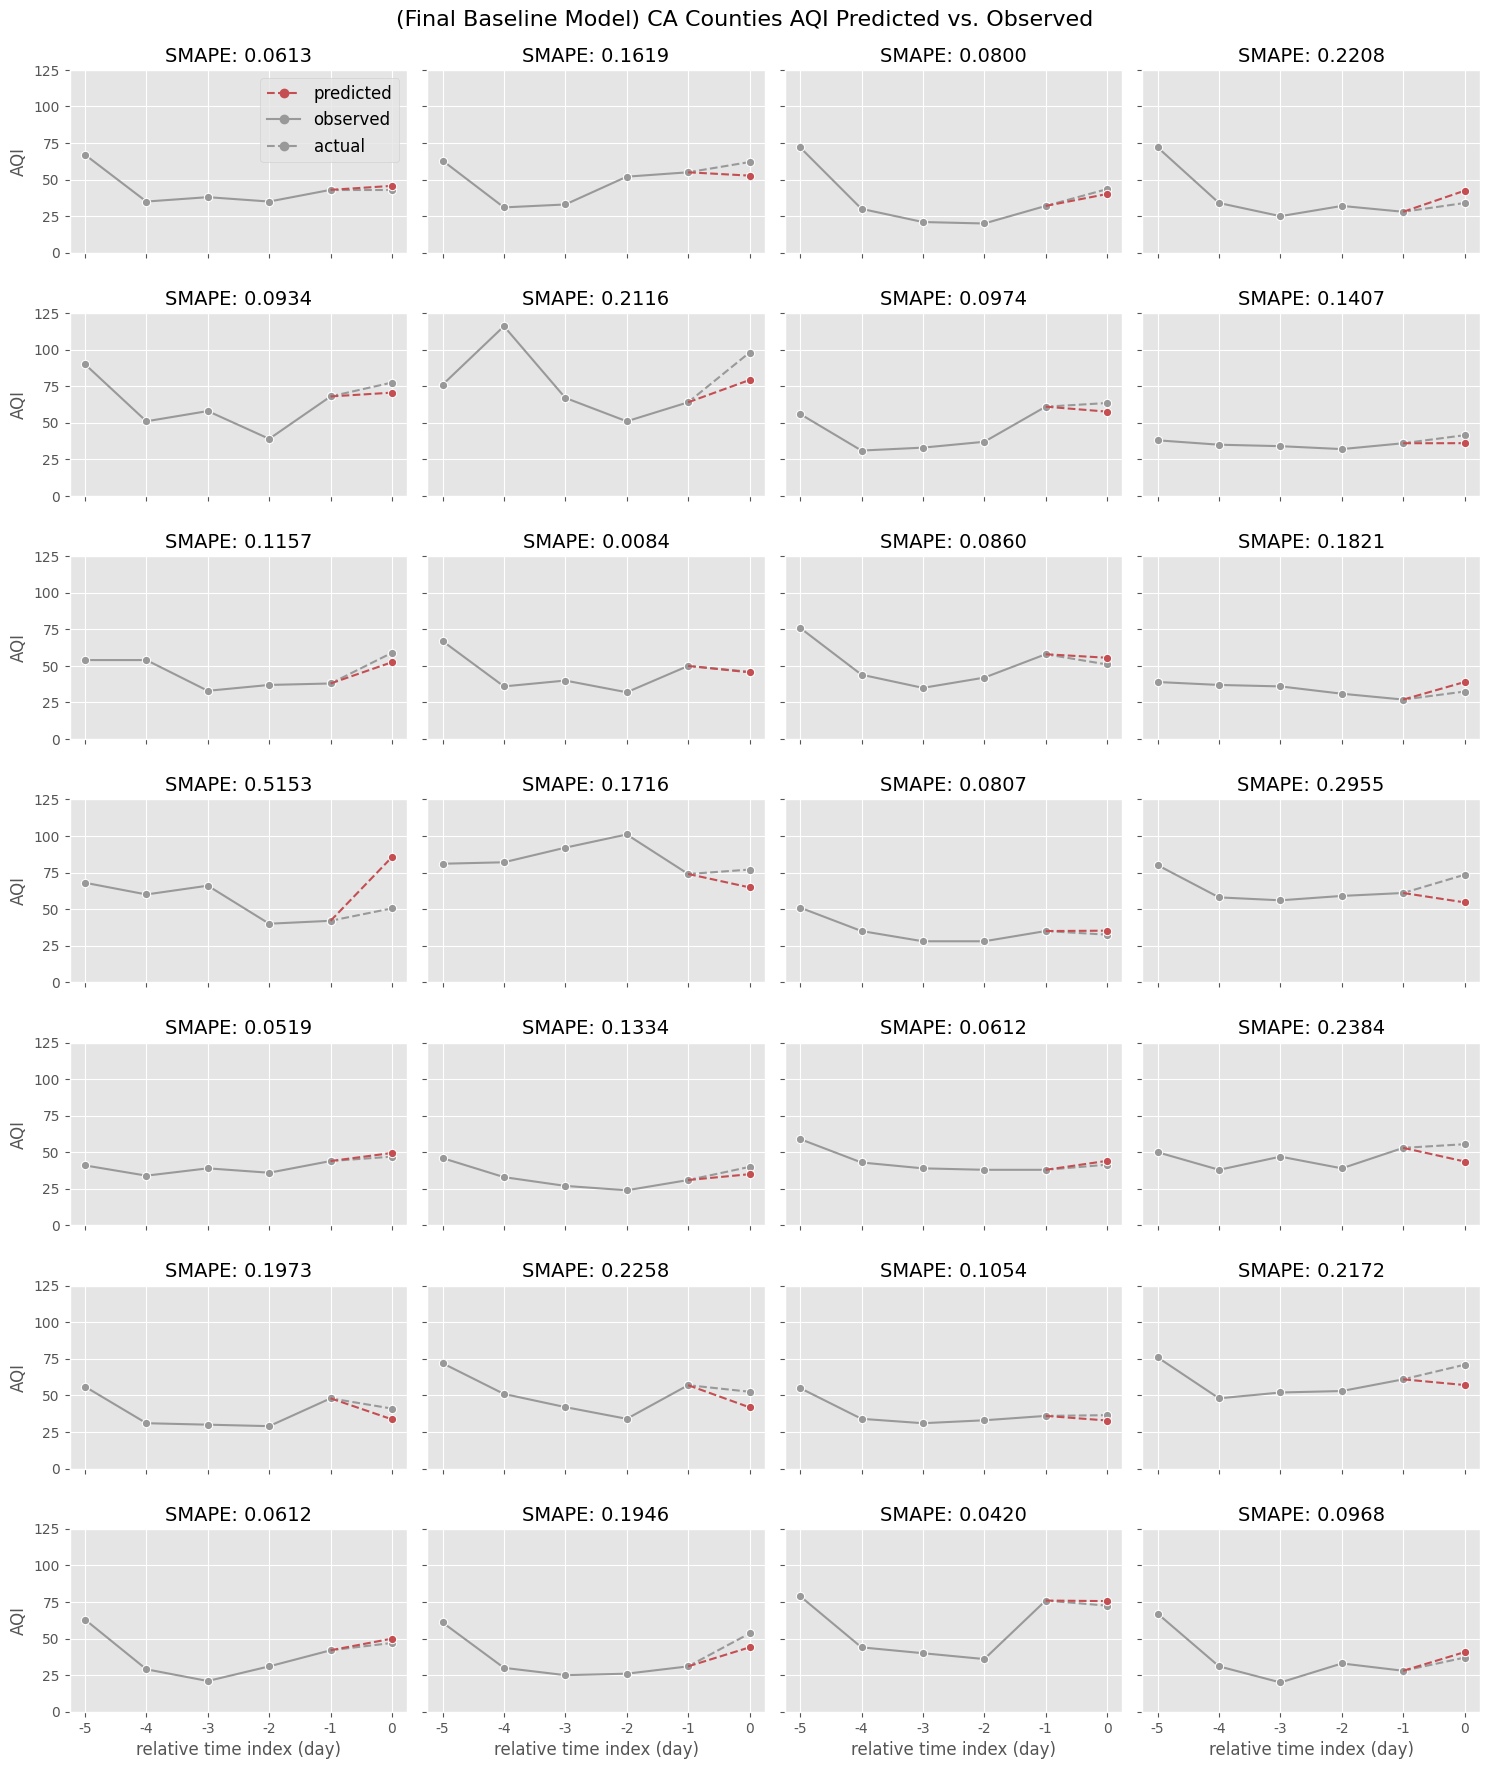

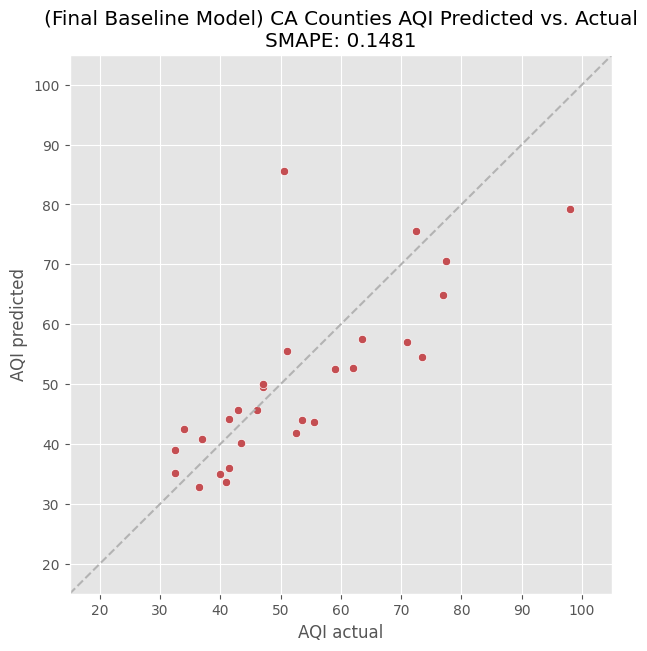

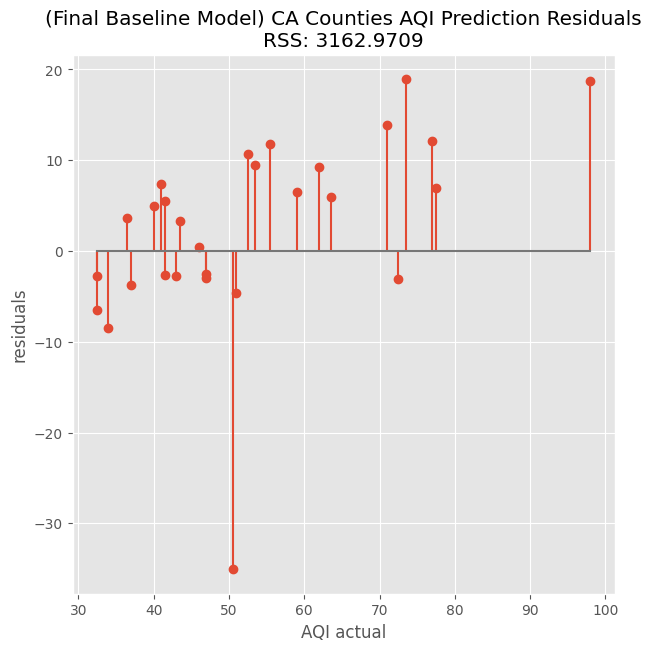

In [ ]:
gc.collect()

def create_time_index(data):
    sorted_year_day = np.sort(data['Date'].unique())
    return data['Date'].map(lambda d: np.where(sorted_year_day == d)[0][0])

def month_to_season(m):
    if ['12',  '1',  '2'].__contains__(m): return 'SP'
    if [ '3',  '4',  '5'].__contains__(m): return 'SU'
    if [ '6',  '7',  '8'].__contains__(m): return 'F'
    if [ '9', '10', '11'].__contains__(m): return 'W'
    return np.nan

# design matrix
# filter CA counties
aqi_five_years = pd.read_csv('data/data_extended/5_years.csv')
aqi_ca_five_years = aqi_five_years[aqi_five_years['state_county'].str.split('_').str[0] == '6']

# rename column for training
aqi_ca_five_years = aqi_ca_five_years.rename(columns={'pm2.5':'pm25'})

# drop counties with extreme aqi values
aqi_ca_five_years['AQI'] = aqi_ca_five_years['AQI'].apply(lambda x: x if x <= 500 else np.nan)

# filter counties having all values for each day
unique_days = aqi_ca_five_years['Date'].nunique()
print('Time index length: {}'.format(unique_days))
aqi_ca_five_years = aqi_ca_five_years.dropna().groupby('state_county') \
                .filter(lambda g: (g['Date'].nunique() == unique_days)) \
                .reset_index().drop(['index'], 1)
print('Counties with full data: {}\n{}'.format(aqi_ca_five_years['state_county'].nunique(),
                                                aqi_ca_five_years['state_county'].unique()))

# wildfire
aqi_ca_five_years = add_wildfire_count(aqi_ca_five_years)

# create time index by week
my_features = aqi_ca_five_years.copy()
my_features['time_index'] = create_time_index(my_features)

# add time-related features (currently not used)
# my_features['month'] = my_features['Date'] \
#                 .map(lambda x: pd.Period(x, freq='D').month) \
#                 .astype(str).astype("category")
# my_features['season'] = my_features['month'].apply(month_to_season)
# my_features['year'] = pd.to_datetime(my_features['Date'], format='%Y-%m-%d') \
#                 .apply(lambda x: x.strftime('%Y'))

# transformation (currently not used)
# my_features['log_AQI_mean'] = np.log(my_features['AQI_mean'] + 0.000000001)

# rename
my_features = my_features.rename(columns={
                                        #   'state_county_':'state_county',
                                        #   'gas_first':'gas',
                                          }) \
                                    .drop(['Date'], 1)

# add GEO info
my_features = intro_location(my_features, level='ca') \
                    .rename(columns={'Latitude':'lat', 'Longitude':'long', 'Elevation':'elev' })

# normalize
AQI_target = my_features['AQI'].copy()
for col in ['AQI',
            'ozone',
            'so2',
            'co',
            'no2',
            'temp',
            'wind',
            'pm25',
            'barometric_pressure',
            'rh_and_dewpoint',
            'lat', 'long', 'elev',
            'gas',
            'num_wildfires'
            ]:
    my_features[col] = (my_features[col] - my_features[col].mean()) / (my_features[col].std())
my_features['AQI_target'] = AQI_target

display(my_features.head())
print('All available features:')
display(pd.Series(my_features.columns))

all_predictions = []

forecast_data = my_features.copy()
# Temporal Fusion Transformer
training_cutoff = forecast_data['time_index'].max() - 1

training = TimeSeriesDataSet(
    forecast_data[lambda x: x.time_index <= training_cutoff],
    time_idx='time_index',
    target='AQI_target',
    group_ids=[
        'state_county'
    ],
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    static_categoricals=[
        'state_county',
        # 'climate'
    ],
    static_reals=[
        # 'lat',
        # 'long',
        # 'elev',
    ],
    time_varying_known_categoricals=[
        # 'month',
        # 'year',
        # 'season'
    ],
    variable_groups={ },
    time_varying_known_reals=[
        'time_index',
        # 'gas',
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        # 'AQI',
        # 'num_wildfires',
        # 'ozone',
        # 'so2',
        # 'co',
        # 'no2',
        # 'pm25',
        # 'temp',
        # 'wind',
        # 'barometric_pressure',
        # 'rh_and_dewpoint',
    ],
    target_normalizer=GroupNormalizer(
        groups=[
            'state_county'
        ],
    ),
    predict_mode=True
)
# create validation set 
validation = TimeSeriesDataSet.from_dataset(
    training, forecast_data, predict=True, stop_randomization=True
)
# create dataloaders
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)
lr_logger = LearningRateMonitor(logging_interval='step')
logger = TensorBoardLogger('lightning_logs')

torch.manual_seed(1234)
pl.seed_everything(1234)
for i in range(5):
    gc.collect()
    # create trainer
    trainer = pl.Trainer(
        max_epochs=30,
        gpus=int(tf.test.gpu_device_name() != ''),
        gradient_clip_val=0.4,
        limit_train_batches=30,
        callbacks=[lr_logger],
        logger=logger,
    )

    # initialize model
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.05,
        hidden_size=16,
        attention_head_size=1,
        dropout=0.3,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=0,
        reduce_on_plateau_patience=5,
    )

    # fit nn
    trainer.fit(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader
    )

    # load the best model from all epoches
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    plt.style.use('ggplot')

    # calculate smape on validation set
    y_val_tensor = torch.cat([y[0] for x, y in iter(val_dataloader)])
    y_pred_tensor = best_tft.predict(val_dataloader)
    all_predictions.append(y_pred_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1))

all_predictions.append(np.median(all_predictions, 0))
x_val = [x for x in val_dataloader][0][0].get('encoder_target')
y_val = y_val_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1)

print('SMAPE: {:.4f}'.format(smape_t(all_predictions[-1], y_val).mean()))

# visualize all nn trained
final_title = '(Baseline Model) '
for y_i in range(len(all_predictions)):
    gc.collect()
    if y_i == len(all_predictions) - 1:
        final_title = '(Final Baseline Model) '
    else:
        continue
    y_pred = all_predictions[y_i]

    # predicted vs. observed
    result_losses = smape_t(y_val, y_pred)
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    results = pd.DataFrame(np.concatenate((x_val, y_val, y_pred, result_losses), axis=1),
                        columns=['-5', '-4', '-3', '-2', '-1', '0', '0_pred', 'loss']) \
                        # .sort_values('loss')

    line_o = Line2D([0], [0], color='0.6', marker='o')
    line_a = Line2D([0], [0], color='0.6', marker='o', linestyle='--')
    line_p = Line2D([0], [0], color='r', marker='o', linestyle='--')

    fig = plt.figure(dpi=100, figsize=(15, 20))
    plt.suptitle(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    for i in range(results.shape[0]):
        ax = fig.add_subplot(results.shape[0]//4 + 1, 4, i+1);
        sns.lineplot(x=results.columns[0:5], y=results.iloc[i, 0:5],
                    color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i, 4:6],
                    linestyle='--', color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i].get(['-1', '0_pred']),
                    linestyle='--', color='r', ax=ax);
        sns.lineplot(x=results.columns[5:6], y=results.iloc[i].get(['0_pred']),
                    linestyle='--', color='r', marker='o', ax=ax);
        ax.set_title('SMAPE: {:.4f}'.format(results.iloc[i,7]), fontsize=14)
        ax.set_ylim(0, 125)
        if i%4 == 0:
            ax.set_ylabel('AQI')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        if results.shape[0] - i <= 4:
            ax.set_xlabel('relative time index (day)')
        else:
            ax.set_xticklabels([])
        if i == 0:
            ax.legend([line_p, line_o, line_a],
                      ['predicted', 'observed', 'actual'],
                      fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # predicted vs. actual
    plt.figure(figsize=(7, 7))
    sns.scatterplot(x=results['0'], y=results['0_pred'], color='r', );
    plt.plot([15, 105], [15, 105], linestyle='--', c='0.7');
    plt.xlim(15, 105);
    plt.ylim(15, 105);
    plt.xlabel('AQI actual');
    plt.ylabel('AQI predicted');
    plt.title(final_title+'CA Counties AQI Predicted vs. Actual\nSMAPE: {:.4f}'.format(np.mean(smape_t(y_val, y_pred))));

    # residuals
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    plt.figure(figsize=(7, 7))
    plt.title(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    residuals = results['0'] - results['0_pred']
    plt.stem(results['0'], residuals, use_line_collection = True)
    plt.ylabel('residuals')
    plt.xlabel('AQI actual')
    plt.title(final_title+'CA Counties AQI Prediction Residuals\nRSS: {:.4f}'.format(np.sum(residuals**2)));

### Summary of Model

For our model, we have decided to use a temporal fusion transformer, which relies on deep neural networks for effective forecasting. Moreover, the temporal fusion transformer allows us to extract information, which if interpreted correctly, can show us which factors contribute towards influencing the predictions. The temporal fusion transformer will utilize input data consisting of the features from 5 days to predict the AQI levels for two days in the future. The inputs to our model are the time_index and county features while the outputs to our model are the AQI levels of future dates. In our experiment we constructed 5 transformers, each of which are trained on 30 epochs, and use 32 CA counties with full AQI data on all 1827 days to test our model on and computed the SMAPE error value. The mean SMAPE value we found was 0.1481, which is a little smaller than the error threshold that we want our model to achieve in our hypothesis, and the sum of the squares of the residuals is 3162.97, which is relatively speaking a very high value. The sum of the squares of residuals is a measure of the variance and how well the model can fit the data, so a higher SSR value shows that our model has lots of room for improvement in terms of fitting the data. For our future model, we first plan on first improving and optimizing the quality of the existing training data by removing any records containing the outliers found in our Principal Component Analysis from part 1 of our project. In addition, we plan on utilizing more features, especially features such as gas consumption, climate patterns, from external data sets, to improve the accuracy of our model and reduce the mean SMAPE error. Finally, we want to increase the number of hidden layers in our neural network model from 16 to 32. Using numerous features can cause the trends and relationships in our training data to be very complex so increasing this amount will allow our model to better fit the training data and understand more complex relationships. 

### Improving Model

Global seed set to 1234
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork   

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

SMAPE: 0.1216


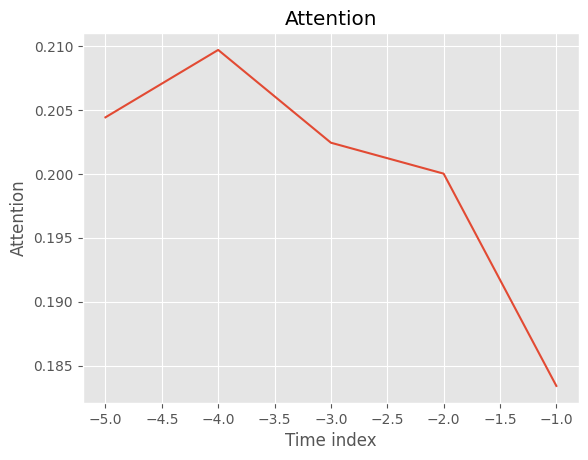

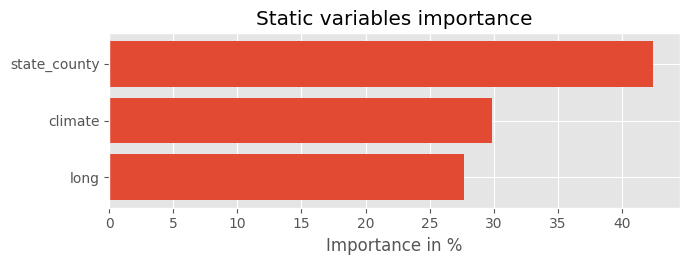

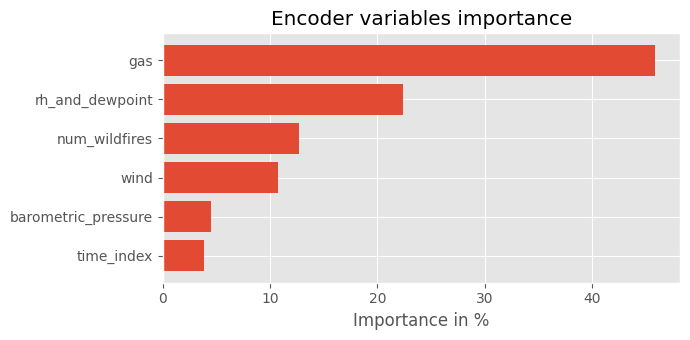

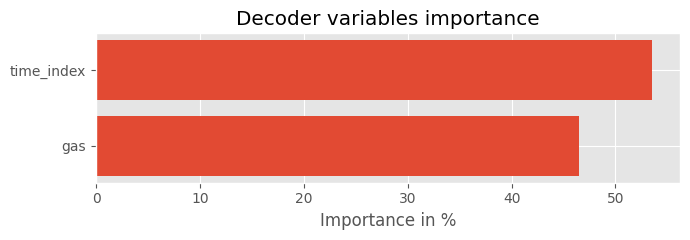

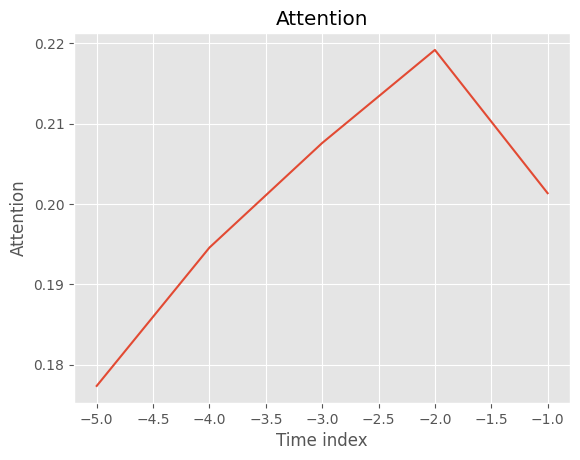

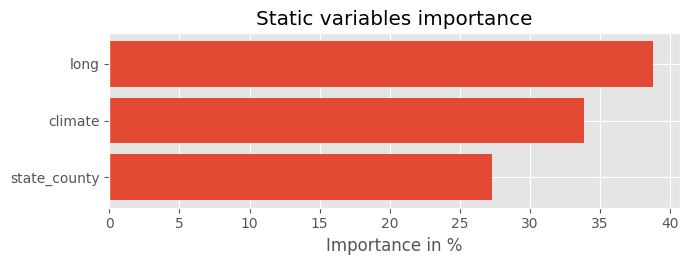

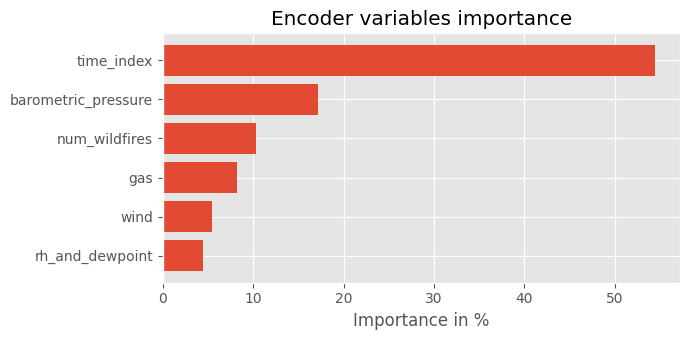

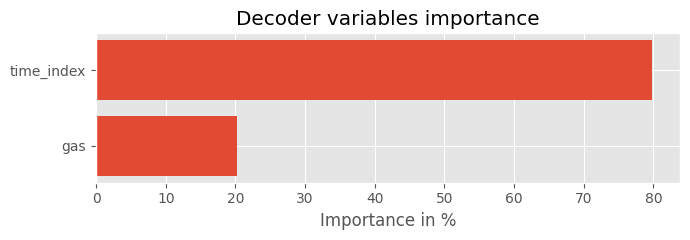

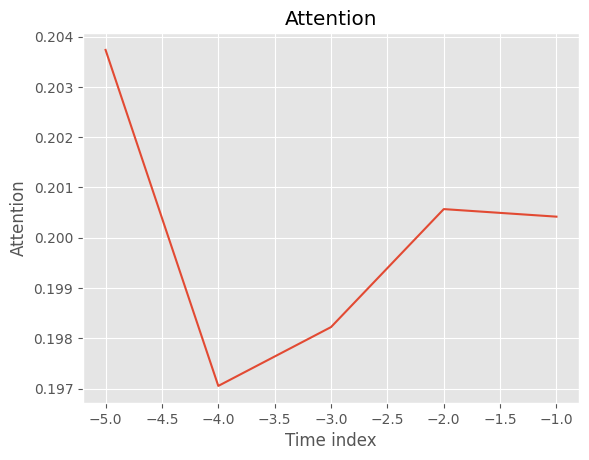

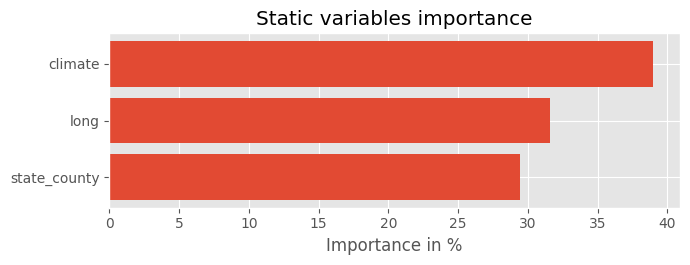

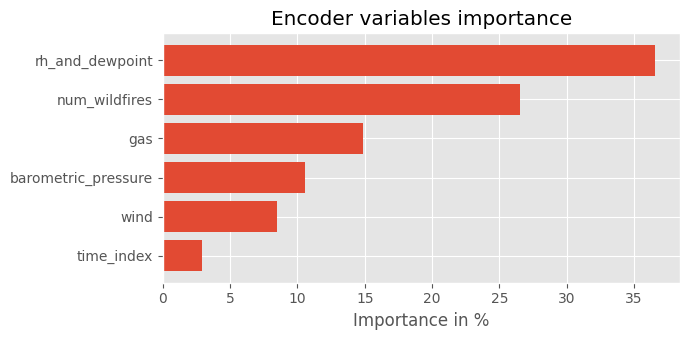

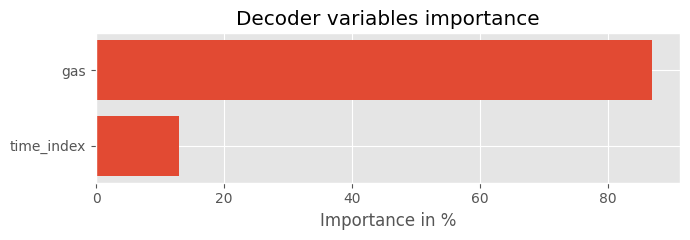

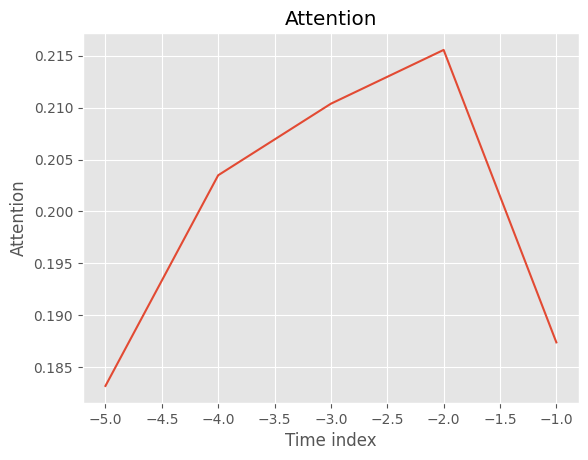

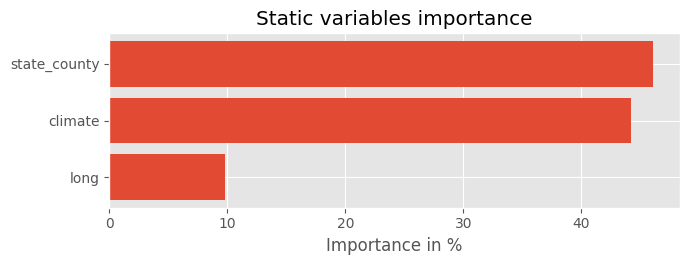

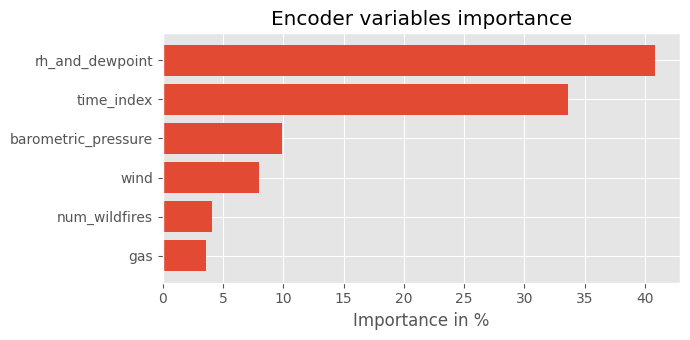

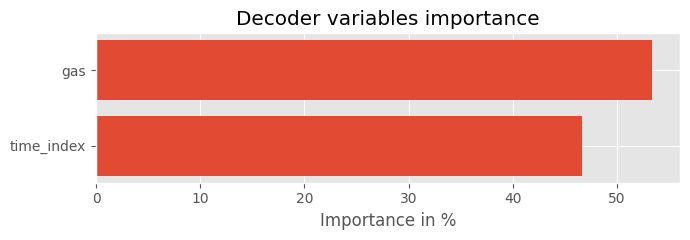

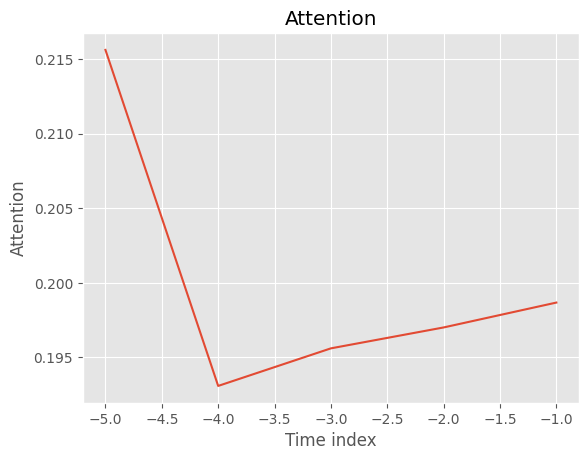

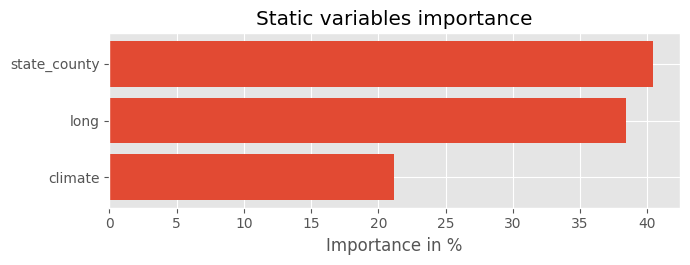

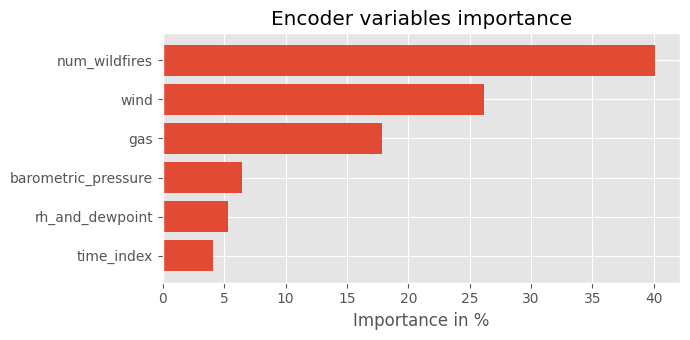

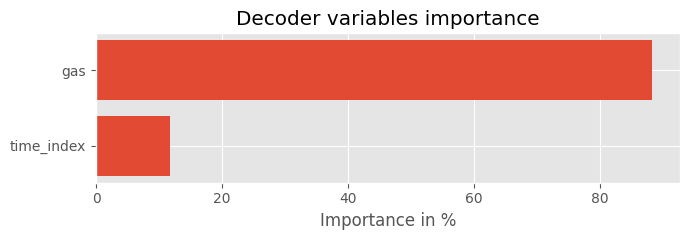

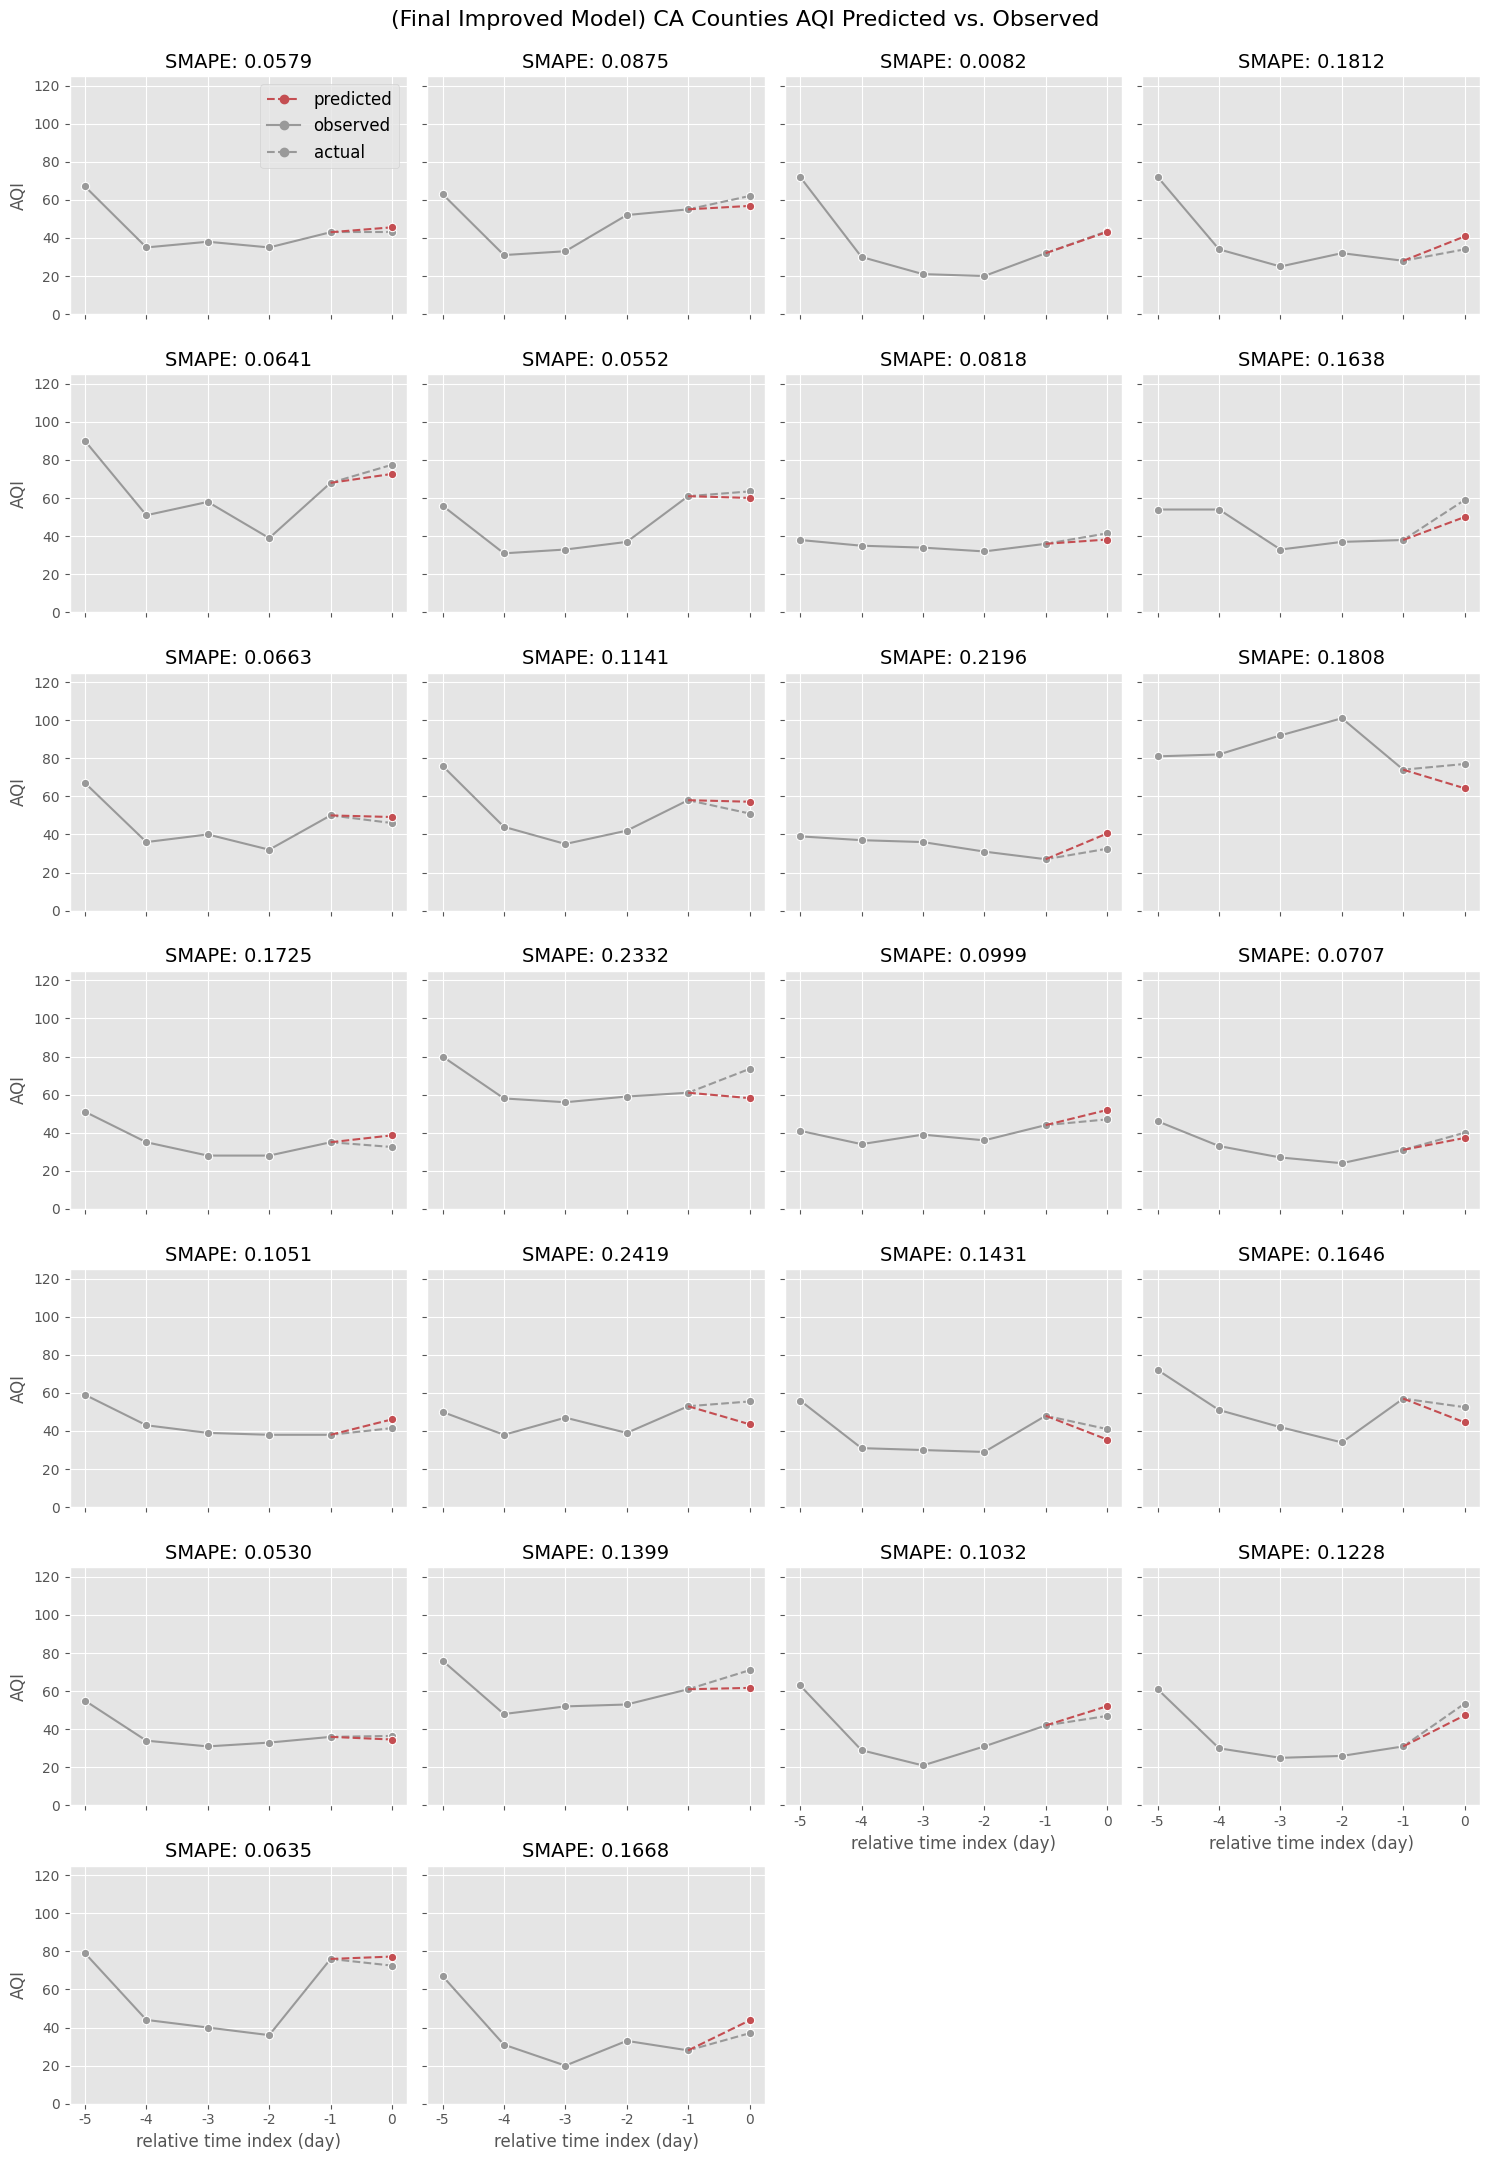

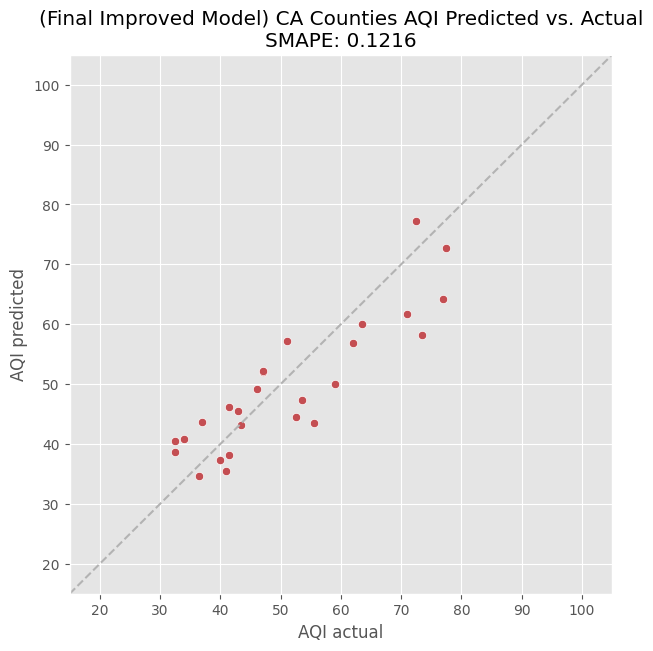

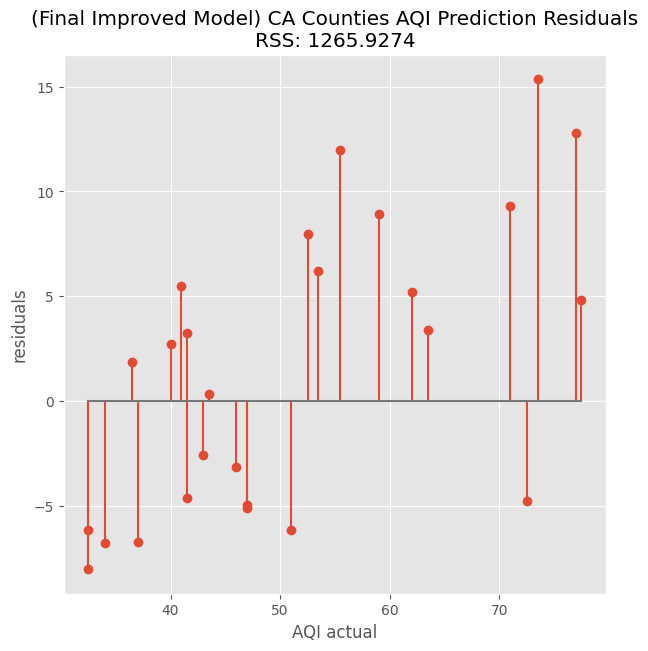

In [ ]:
# remove four outliers we identified from pca
outliers = ['6_037', '6_065', '6_051', '6_071']
my_features = my_features[~my_features['state_county'].isin(outliers)]

all_predictions = []

forecast_data = my_features.copy()
# Temporal Fusion Transformer with more features
training_cutoff = forecast_data['time_index'].max() - 1

training = TimeSeriesDataSet(
    forecast_data[lambda x: x.time_index <= training_cutoff],
    time_idx='time_index',
    target='AQI_target',
    group_ids=[
        'state_county'
    ],
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    static_categoricals=[
        'state_county',
        'climate',
    ],
    static_reals=[
        # 'lat',
        'long',
        # 'elev',
    ],
    time_varying_known_categoricals=[
        # 'month',
        # 'year',
        # 'season'
    ],
    variable_groups={ },
    time_varying_known_reals=[
        'time_index',
        'gas',
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        # 'AQI',
        'num_wildfires',
        # 'ozone',
        # 'so2',
        # 'co',
        # 'no2',
        # 'pm25',
        # 'temp',
        'wind',
        'barometric_pressure',
        'rh_and_dewpoint',
    ],
    target_normalizer=GroupNormalizer(
        groups=[
            'state_county', 
        ],
    ),
    predict_mode=True
)

# create validation set 
validation = TimeSeriesDataSet.from_dataset(
    training, forecast_data, predict=True, stop_randomization=True
)
# create dataloaders
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)
lr_logger = LearningRateMonitor(logging_interval='step')
logger = TensorBoardLogger('lightning_logs')

torch.manual_seed(1234)
pl.seed_everything(1234)
for i in range(5):
    gc.collect()
    # create trainer
    trainer = pl.Trainer(
        max_epochs=30,
        gpus=int(tf.test.gpu_device_name() != ''),
        gradient_clip_val=0.4,
        limit_train_batches=30,
        callbacks=[lr_logger],
        logger=logger,
    )

    # initialize model
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.05,
        hidden_size=32,
        attention_head_size=1,
        dropout=0.3,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=0,
        reduce_on_plateau_patience=5,
    )

    # fit nn
    trainer.fit(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader
     )

    # load the best model from all epoches
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    plt.style.use('ggplot')

    # calculate smape on validation set
    y_val_tensor = torch.cat([y[0] for x, y in iter(val_dataloader)])
    y_pred_tensor = best_tft.predict(val_dataloader)
    all_predictions.append(y_pred_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1))

    # visualize nn interpretations
    raw_predictions, _ = best_tft.predict(val_dataloader, mode='raw', return_x=True)
    interpretation = best_tft.interpret_output(
        raw_predictions, reduction="sum"
    )
    best_tft.plot_interpretation(interpretation)

all_predictions.append(np.median(all_predictions, 0))
x_val = [x for x in val_dataloader][0][0].get('encoder_target')
y_val = y_val_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1)
print('SMAPE: {:.4f}'.format(smape_t(all_predictions[-1], y_val).mean()))

# visualize all nn trained
final_title = '(Improved Model) '
for y_i in range(len(all_predictions)):
    gc.collect()
    if y_i == len(all_predictions) - 1:
        final_title = '(Final Improved Model) '
    else:
        continue
    y_pred = all_predictions[y_i]

    # predicted vs. observed  
    result_losses = smape_t(y_val, y_pred)
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    results = pd.DataFrame(np.concatenate((x_val, y_val, y_pred, result_losses), axis=1),
                        columns=['-5', '-4', '-3', '-2', '-1', '0', '0_pred', 'loss']) \
                        # .sort_values('loss')

    line_o = Line2D([0], [0], color='0.6', marker='o')
    line_a = Line2D([0], [0], color='0.6', marker='o', linestyle='--')
    line_p = Line2D([0], [0], color='r', marker='o', linestyle='--')

    fig = plt.figure(dpi=100, figsize=(15, 22))
    plt.suptitle(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    for i in range(results.shape[0]):
        ax = fig.add_subplot(results.shape[0]//4 + 1, 4, i+1);
        sns.lineplot(x=results.columns[0:5], y=results.iloc[i, 0:5],
                    color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i, 4:6],
                    linestyle='--', color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i].get(['-1', '0_pred']),
                    linestyle='--', color='r', ax=ax);
        sns.lineplot(x=results.columns[5:6], y=results.iloc[i].get(['0_pred']),
                    linestyle='--', color='r', marker='o', ax=ax);
        ax.set_title('SMAPE: {:.4f}'.format(results.iloc[i,7]), fontsize=14)
        ax.set_ylim(0, 125)
        if i%4 == 0:
            ax.set_ylabel('AQI')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        if results.shape[0] - i <= 4:
            ax.set_xlabel('relative time index (day)')
        else:
            ax.set_xticklabels([])
        if i == 0:
            ax.legend([line_p, line_o, line_a],
                      ['predicted', 'observed', 'actual'],
                      fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # predicted vs. actual
    plt.figure(figsize=(7, 7))
    sns.scatterplot(x=results['0'], y=results['0_pred'], color='r');
    plt.plot([15, 105], [15, 105], linestyle='--', c='0.7');
    plt.xlim(15, 105);
    plt.ylim(15, 105);
    plt.xlabel('AQI actual');
    plt.ylabel('AQI predicted');
    plt.title(final_title+'CA Counties AQI Predicted vs. Actual\nSMAPE: {:.4f}'.format(np.mean(smape_t(y_val, y_pred))));

    # residuals
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    plt.figure(figsize=(7, 7))
    plt.title(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    residuals = results['0'] - results['0_pred']
    plt.stem(results['0'], residuals, use_line_collection = True)
    plt.ylabel('residuals')
    plt.xlabel('AQI actual')
    plt.title(final_title+'CA Counties AQI Prediction Residuals\nRSS: {:.4f}'.format(np.sum(residuals**2)));

### Comparing Baseline Model to Neural Network

The final model does seem to have better accuracy than the baseline model. After running our trials similar to how they were conducted for our baseline model, we found the mean SMAPE value to be 0.1216, which is about 3 percent lower. Thus, we were able to successfully validate our first part of the hypothesis, which was “With the integration of creative features such as gas consumption and climate types from external datasets and without relying on any previous AQI or air pollutant concentrations levels, future AQI can be forecasted with at most 15% symmetric mean absolute percentage error” as we were able to create a model with a SMAPE much lower than 15% without usually obviously correlated features such as the air pollutant concentration levels. Moreover, the sum of the squared residuals of our model was 1265.92, which shows an improvement in accuracy since it is significantly lower than the SSR in the baseline model, which was 3162.97. However, we verified that the second part of our hypothesis is incorrect, which was “Gas consumption and the frequency/periodicity of wildfires will be the two most important features that contribute towards the accuracy of our model.” The importance of features in our transformer model is inconsistent and always changing due to the fact that in a neural network, features will have more weight than others in certain scenarios and will have less weight than others in other scenarios which shows that gas consumption and frequency of wildfires are the not most important features in our model. A research question that we were able to answer is whether the magnitude of the reduction in SMAPE warrants the use of extra external features in our model. Our conclusion to this question is that since the reduction in SMAPE is only 3%, the use of 8 more external features cannot be justified since it can cause model complexity, run time, and space complexity to drastically increase. Our final model shows that the 2 features that our baseline model utilizes have a relatively high accuracy on their own.  Another conclusion that we were able to make was that the temporal fusion transformer was a very powerful model that was very well suited for this model since it was able to attain a high accuracy using only two features. 